In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rohlik-orders-forecasting-challenge/test_calendar.csv
/kaggle/input/rohlik-orders-forecasting-challenge/solution_example.csv
/kaggle/input/rohlik-orders-forecasting-challenge/train.csv
/kaggle/input/rohlik-orders-forecasting-challenge/test.csv
/kaggle/input/rohlik-orders-forecasting-challenge/train_calendar.csv


# Rohlik Orders Prediction

# Dataset Description
* You are provided with historical orders data for selected Rohlik warehouses. The task is to forecast the "orders" column for the test set. Some features are not available in test as they are not known at the moment of making the prediction (e.g. precipitation, shutdown, user activity on website). These are market in the description below.

# Files
* train.csv - the training set containing the historical orders data and selected features described below
* test.csv - the test set
* solution_example.csv - a sample submission file in the correct format
* train_calendar.csv - a calendar for the training set containing data about holidays or warehouse specific events, some columns are already in the train data but there are additional rows in this file for dates where some warehouses could be closed due to public holiday or Sunday (and therefore they are not in the train set)
* test_calendar.csv - a calendar for the test set

# STEP 0: Importing Libraries

* skimpy: This library provides tools for quick exploratory data analysis, making it easier to inspect and visualize your data.
* fastdtw: This is a Python implementation of the Fast Dynamic Time Warping algorithm, useful for measuring similarity between time-series data.

In [2]:
!pip install skimpy
!pip install fastdtw
!pip install colorama


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 41.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: polars
    Found existing installation: polars 1.1.0
    Uninstalling polars-1.1.0:
      Successfully uninstalled polars-1.1.0
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import itertools
import warnings
import gc
import re
import scipy
from sklearn.compose import TransformedTargetRegressor
from sklearn import set_config
from colorama import Style, Fore
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict, GroupKFold, TimeSeriesSplit
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import Ridge, RidgeCV
from matplotlib.dates import MonthLocator, DateFormatter
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, HistGradientBoostingRegressor, BaggingRegressor
from lightgbm import LGBMRegressor
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer,mean_squared_error, mean_absolute_error, silhouette_score
from sklearn.linear_model import TweedieRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as DateFormatter
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, HistGradientBoostingClassifier
import math
from fastdtw import fastdtw
from sklearn.cluster       import AgglomerativeClustering
import skimpy


In [4]:
SUBMIT = True

In [5]:
from bs4 import BeautifulSoup

In [6]:
from colorama import Fore, Style, init

# Initialize colorama
init(autoreset=True)

def printColor(pText: str):
    print(f'{Style.BRIGHT}{Fore.BLUE}{pText}{Style.RESET_ALL}')

# STEP 1: Reading the file 

In [7]:
# Loading the data
train = pd.read_csv(r'/kaggle/input/rohlik-orders-forecasting-challenge/train.csv', index_col='id')
train_calendar = pd.read_csv(r'/kaggle/input/rohlik-orders-forecasting-challenge/train_calendar.csv')
test = pd.read_csv(r'/kaggle/input/rohlik-orders-forecasting-challenge/test.csv', index_col='id')
test_calendar = pd.read_csv(r'/kaggle/input/rohlik-orders-forecasting-challenge/test_calendar.csv')
sub = pd.read_csv(r'/kaggle/input/rohlik-orders-forecasting-challenge/solution_example.csv')


# STEP 2: Data Understanding

In [8]:
import pandas as pd
import random
from IPython.display import HTML, display

# Function to style tables
def style_table(df):
    styled_df = df.style.set_table_styles([
        {"selector": "th", "props": [("color", "white"), ("background-color", "#6a1b9a")]}
    ]).set_properties(**{"text-align": "center"}).hide(axis="index")
    return styled_df.to_html()

# Function to create styled heading with emojis
def styled_heading(text, background_color='#6a1b9a', text_color='white'):
    return f"""
    <div style="
        text-align: center;
        background: {background_color};
        color: {text_color};
        padding: 20px;
        font-size: 24px;
        font-weight: bold;
        border-radius: 10px;
        margin-bottom: 20px;
        box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1);
        border: 2px solid {background_color};
    ">
        {text}
    </div>
    """

def print_dataset_analysis(dataset, dataset_name, n_top=5, heading_color='#6a1b9a', text_color='white'):
    heading = styled_heading(f"📊 {dataset_name} Overview", heading_color, text_color)
    display(HTML(heading))
    
    display(HTML("<h2 style='font-size: 18px; margin-top: 18px;'>📏 Shape of the Dataset</h2>"))
    display(HTML(f"<p>{dataset.shape[0]} rows and {dataset.shape[1]} columns</p>"))
    
    display(HTML("<h2 style='font-size: 18px; margin-top: 18px;'>🔍 First 5 Rows</h2>"))
    display(HTML(style_table(dataset.head(n_top))))
    
    display(HTML("<h2 style='font-size: 18px; margin-top: 18px;'>📊 Summary Statistics</h2>"))
    display(HTML(style_table(dataset.describe())))
    
    display(HTML("<h2 style='font-size: 18px; margin-top: 18px;'>🔧 Null Values</h2>"))
    null_counts = dataset.isnull().sum()
    if null_counts.sum() == 0:
        display(HTML("<p>No null values found.</p>"))
    else:
        display(HTML(style_table(null_counts[null_counts > 0].to_frame(name='Null Values'))))
    
    display(HTML("<h2 style='font-size: 18px; margin-top: 18px;'>♻️ Duplicate Rows</h2>"))
    duplicate_count = dataset.duplicated().sum()
    display(HTML(f"<p>{duplicate_count} duplicate rows found.</p>"))
    
    display(HTML("<h2 style='font-size: 18px; margin-top: 18px;'>🗂️ Data Types</h2>"))
    dtypes_table = pd.DataFrame({
        'Column Name': dataset.columns,
        'Data Type': [dataset[col].dtype for col in dataset.columns]
    })
    display(HTML(style_table(dtypes_table)))
    
    display(HTML("<h2 style='font-size: 18px; margin-top: 18px;'>📋 Column Names</h2>"))
    display(HTML(f"<p>{', '.join(dataset.columns)}</p>"))
    
    display(HTML("<h2 style='font-size: 18px; margin-top: 18px;'>🔢 Unique Values</h2>"))
    unique_values_table = pd.DataFrame({
        'Column Name': dataset.columns,
        'Unique Values': [', '.join(map(str, dataset[col].unique()[:7])) + (', ...' if len(dataset[col].unique()) > 7 else '') for col in dataset.columns]
    })
    display(HTML(style_table(unique_values_table)))

# Load datasets
train = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train.csv', index_col='id')
train_calendar = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train_calendar.csv')
test = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test.csv', index_col='id')
test_calendar = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test_calendar.csv')
sub = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/solution_example.csv')

# Print dataset analyses
print_dataset_analysis(train, "Training Data", heading_color='#004d00')  # Green
print_dataset_analysis(train_calendar, "Calendar Training Data", heading_color='#4B0082')  # Purple
print_dataset_analysis(test, "Test Data", heading_color='#004d00')  # Green
print_dataset_analysis(test_calendar, "Calendar Testing Data", heading_color='#4B0082')  # Purple
print_dataset_analysis(sub, "Sample Solution", heading_color='#388e3c')  # Green


In [9]:
from IPython.display import HTML, display

# Define a function to create colored text for Jupyter Notebooks
def colored_text(text, color):
    return f'<p style="color:{color}; font-weight:bold;">{text}</p>'
# Define initial features and target
initial_features = list(test.columns)
target = 'orders'

# Print colored text in Jupyter Notebook
display(HTML(colored_text(f'Initial features: {", ".join(initial_features)}', 'green')))
display(HTML(colored_text(f'Target: {target}', 'blue')))

In [10]:
# Use skimpy to generate a summary
skimpy.skim(train[initial_features + [target]])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7340   │ │ int64       │ 4     │                                                          │
│ │ Number of columns │ 8      │ │ string      │ 3     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name             ┃ NA  ┃ NA %  ┃ mean      ┃ sd       ┃ p0   ┃ p25   ┃ p50  ┃ p75  ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ holiday                 │   0 │     0 │   0.02725 │   0.1628 │    0 │     0 │    0 │    0 │     1 │   ▇    │  │
│ │ shops_closed            │   0 │     0 │    0.0109 │   0.1038 │    0 │     0 │    0 │    0 │     1 │   ▇    │  │
│ │ winter_school_holidays  │   0 │     0 │   0.02997 │   0.1705 │    0 │     0 │    0 │    0 │     1 │   ▇    │  │
│ │ school_holidays         │   0 │     0 │  0.007084 │  0.08388 │    0 │     0 │    0 │    0 │     1 │   ▇    │  │
│ │ orders                  │   0 │     0 │      5535 │     2183 │  790 │  4434 │ 5370 │ 7009 │ 18140 │  ▂▇▅▁  │  │
│ └─────────────────────────┴─────┴───────┴───────────┴──────────┴──────┴───────┴──────┴──────┴───────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA         ┃ NA %        ┃ words per row              ┃ total words            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ warehouse                 │          0 │           0 │                          1 │                   7340 │  │
│ │ date                      │          0 │           0 │                          1 │                   7340 │  │
│ │ holiday_name              │       7122 │       97.03 │                      0.095 │                    697 │  │
│ └───────────────────────────┴────────────┴─────────────┴────────────────────────────┴────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [11]:
# Apply skimpy to get a summary of the test dataframe
skimpy.skim(test)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 397    │ │ int64       │ 4     │                                                          │
│ │ Number of columns │ 7      │ │ string      │ 3     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━┳━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name               ┃ NA  ┃ NA %   ┃ mean      ┃ sd       ┃ p0  ┃ p25  ┃ p50  ┃ p75  ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━╇━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ holiday                   │   0 │      0 │   0.06801 │   0.2521 │   0 │    0 │    0 │    0 │    1 │ ▇    ▁ │  │
│ │ shops_closed              │   0 │      0 │   0.02015 │   0.1407 │   0 │    0 │    0 │    0 │    1 │   ▇    │  │
│ │ winter_school_holidays    │   0 │      0 │   0.02015 │   0.1407 │   0 │    0 │    0 │    0 │    1 │   ▇    │  │
│ │ school_holidays           │   0 │      0 │   0.07053 │   0.2564 │   0 │    0 │    0 │    0 │    1 │ ▇    ▁ │  │
│ └───────────────────────────┴─────┴────────┴───────────┴──────────┴─────┴──────┴──────┴──────┴──────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA       ┃ NA %         ┃ words per row               ┃ total words            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ warehouse                 │        0 │            0 │                           1 │                    397 │  │
│ │ date                      │        0 │            0 │                           1 │                    397 │  │
│ │ holiday_name              │      380 │        95.72 │                         0.1 │                     40 │  │
│ └───────────────────────────┴──────────┴──────────────┴─────────────────────────────┴────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

# STEP 3: Data Cleaning 

In [12]:
# Process both dataframes
for df in [train, test]:
    df['date'] = pd.to_datetime(df['date'])  # Convert 'date' column to datetime
    df['holiday_name'] = df['holiday_name'].fillna('None')  # Fill missing values in 'holiday_name' column


In [13]:
train.isnull().sum()

warehouse                   0
date                        0
orders                      0
holiday_name                0
holiday                     0
shutdown                    0
mini_shutdown               0
shops_closed                0
winter_school_holidays      0
school_holidays             0
blackout                    0
mov_change                  0
frankfurt_shutdown          0
precipitation             270
snow                      270
user_activity_1             0
user_activity_2             0
dtype: int64

In [14]:
test.isnull().sum()

warehouse                 0
date                      0
holiday_name              0
holiday                   0
shops_closed              0
winter_school_holidays    0
school_holidays           0
dtype: int64

In [15]:

print('Train')
print(f'first date (train) : {train.date.min()}')
print(f'last date (train) : {train.date.max()}')
print(f'interval (train) : {train.date.max()-train.date.min()}')
print(40*'*')
print('\nTest')
print(f'first date (test) : {test.date.min()}')
print(f'last date (test) : {test.date.max()}')
print(f'interval (test) : {test.date.max()-test.date.min()}')

Train
first date (train) : 2020-12-05 00:00:00
last date (train) : 2024-03-15 00:00:00
interval (train) : 1196 days 00:00:00
****************************************

Test
first date (test) : 2024-03-16 00:00:00
last date (test) : 2024-05-15 00:00:00
interval (test) : 60 days 00:00:00


In [16]:
for  w in train.warehouse.unique():
    print(f'{Style.BRIGHT}{Fore.BLUE}**{w}**{Style.RESET_ALL}')
    print(f'  First date: {train.loc[train.warehouse==w].date.min().strftime("%Y-%m-%d")}')
    print(f'  Last  date: {train.loc[train.warehouse==w].date.max().strftime("%Y-%m-%d")}')        
    print(f'{Style.BRIGHT}{Fore.YELLOW} Missing Dates-> {Style.RESET_ALL}{pd.date_range(start=train.loc[train.warehouse==w].date.min(),end=train.loc[train.warehouse==w].date.max()).difference(train.loc[train.warehouse==w].date)}\n')
    

**Prague_1**
  First date: 2020-12-05
  Last  date: 2024-03-15
 Missing Dates-> DatetimeIndex(['2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25'], dtype='datetime64[ns]', freq=None)

**Brno_1**
  First date: 2020-12-05
  Last  date: 2024-03-15
 Missing Dates-> DatetimeIndex(['2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25'], dtype='datetime64[ns]', freq=None)

**Prague_2**
  First date: 2020-12-05
  Last  date: 2024-03-15
 Missing Dates-> DatetimeIndex(['2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25'], dtype='datetime64[ns]', freq=None)

**Prague_3**
  First date: 2020-12-05
  Last  date: 2024-03-15
 Missing Dates-> DatetimeIndex(['2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25'], dtype='datetime64[ns]', freq=None)

**Munich_1**
  First date: 2021-07-21
  Last  date: 2024-03-15
 Missing Dates-> DatetimeIndex(['2021-07-22', '2021-07-23', '2021-07-24', '2021-07-25',
               '2021-07-26', '2021-07-27', '2021-07-28', '2021-07-30',
               '2021-07-31',

# STEP 4 : Data Modeling(Feature Engineering)

In [17]:

train['date_year'] = pd.to_datetime(train['date']).dt.year
train['date_month'] = pd.to_datetime(train['date']).dt.month
train['week_of_year'] = pd.to_datetime(train['date']).apply(lambda x: x.isocalendar()[1])
train['date_day_of_week'] = pd.to_datetime(train['date']).dt.dayofweek
train['date_day'] = pd.to_datetime(train['date']).dt.day
train['date_hour'] = pd.to_datetime(train['date']).dt.hour

test['date_year'] = pd.to_datetime(test['date']).dt.year
test['date_month'] = pd.to_datetime(test['date']).dt.month
test['week_of_year'] = pd.to_datetime(test['date']).apply(lambda x: x.isocalendar()[1])
test['date_day_of_week'] = pd.to_datetime(test['date']).dt.dayofweek
test['date_day'] = pd.to_datetime(test['date']).dt.day
test['date_hour'] = pd.to_datetime(test['date']).dt.hour

# STEP 5 : Data Visualization

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7340 entries, Prague_1_2020-12-05 to Budapest_1_2024-03-14
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   warehouse               7340 non-null   object        
 1   date                    7340 non-null   datetime64[ns]
 2   orders                  7340 non-null   float64       
 3   holiday_name            7340 non-null   object        
 4   holiday                 7340 non-null   int64         
 5   shutdown                7340 non-null   int64         
 6   mini_shutdown           7340 non-null   int64         
 7   shops_closed            7340 non-null   int64         
 8   winter_school_holidays  7340 non-null   int64         
 9   school_holidays         7340 non-null   int64         
 10  blackout                7340 non-null   int64         
 11  mov_change              7340 non-null   float64       
 12  frankfurt_shutdown

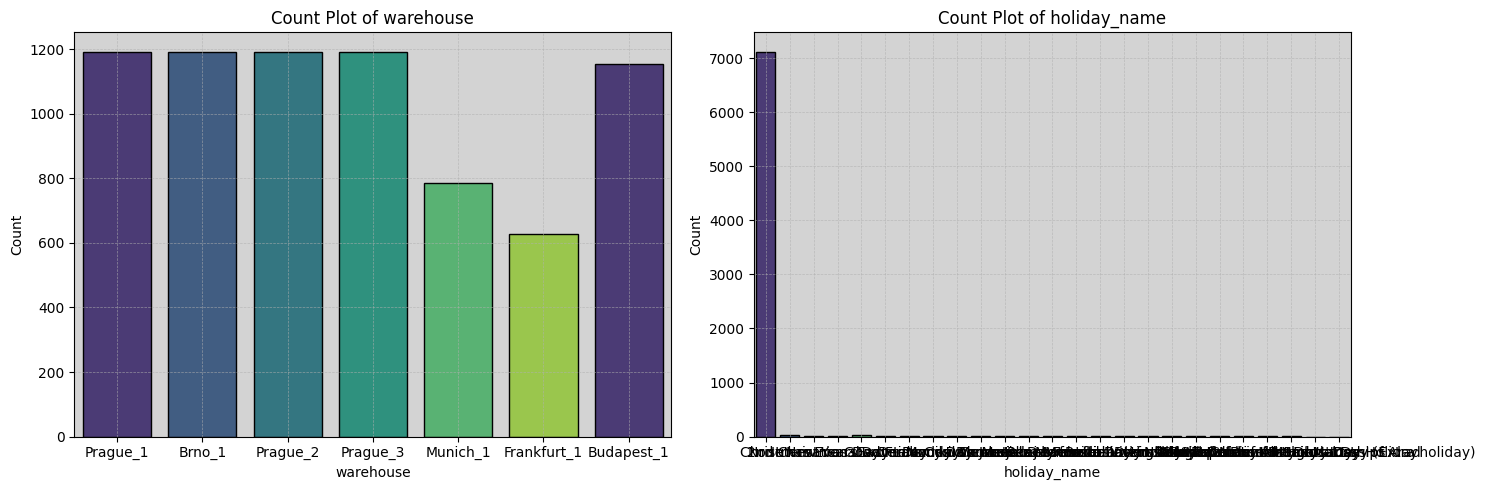

In [19]:
# Define a color palette
palette = sns.color_palette("viridis")

# Categorical features to plot
categorical_features = ['warehouse', 'holiday_name']

plt.figure(figsize=(15, 5))  # Adjusted figure size

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, 2, i)
    
    # Ensure the feature exists in the DataFrame
    if feature in train.columns:
        # Create the count plot
        sns.countplot(data=train, x=feature, palette=palette, edgecolor='black')
        
        # Add background color and grid
        plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.gca().set_facecolor('lightgrey')
        
        # Add titles and labels
        plt.title(f'Count Plot of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Count')
    else:
        print(f"Column '{feature}' not found in DataFrame.")

plt.tight_layout()
plt.show()

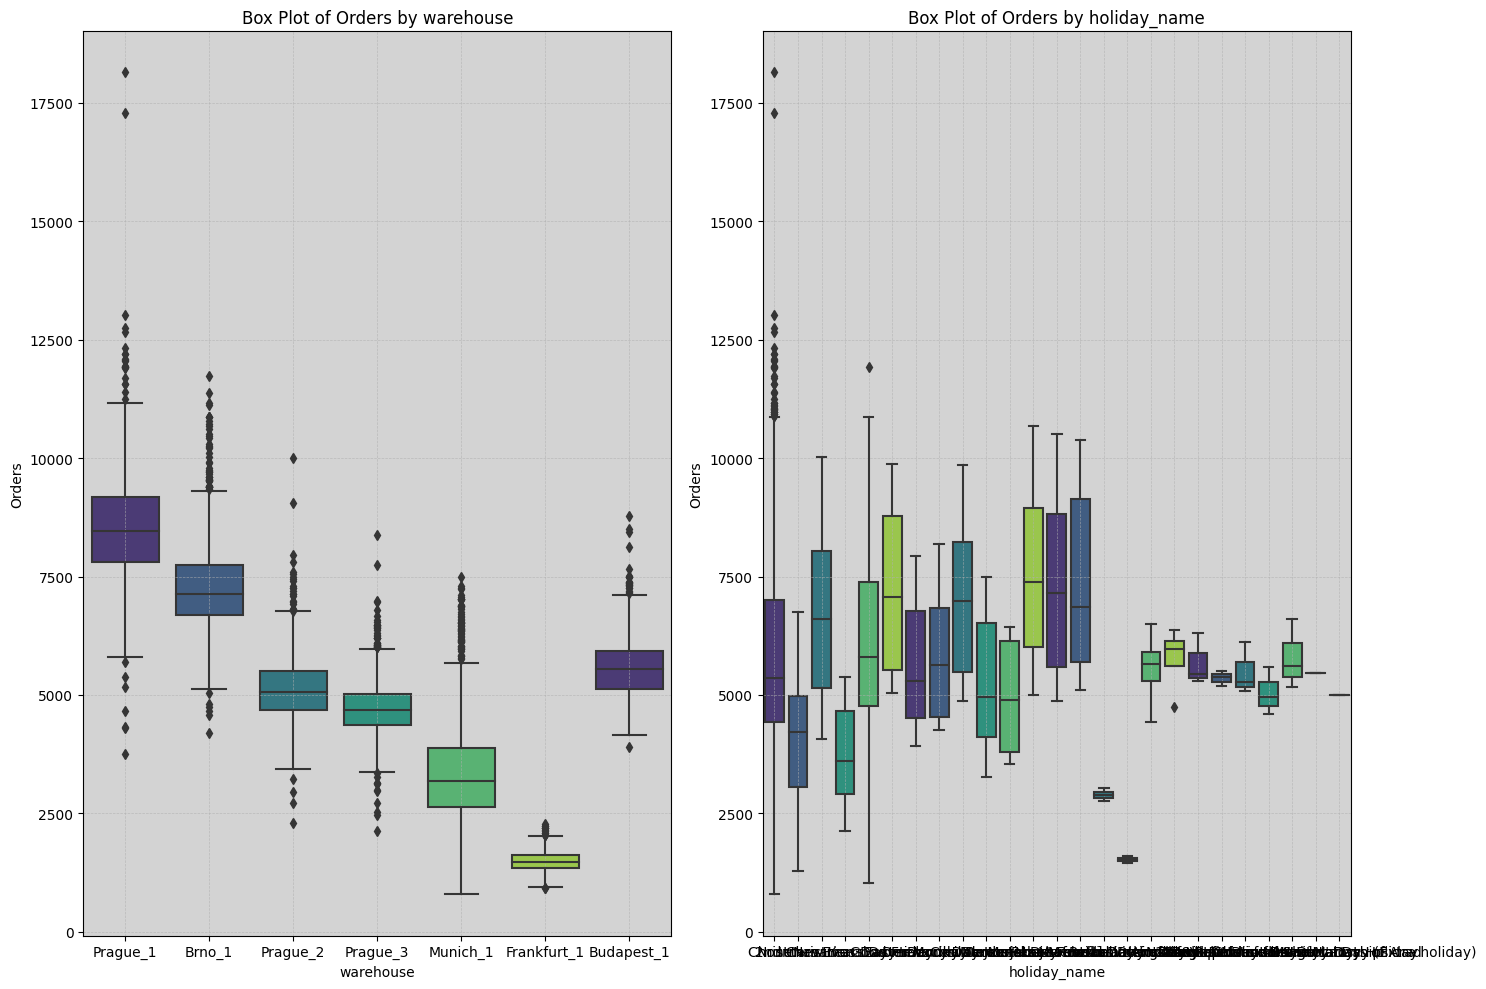

In [20]:
plt.figure(figsize=(15, 10))

# Categorical features to plot
categorical_features = ['warehouse', 'holiday_name']

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, 2, i)
    
    # Create the box plot
    sns.boxplot(data=train, x=feature, y='orders', palette=palette)
    
    # Add background color and grid
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.gca().set_facecolor('lightgrey')
    
    # Add titles and labels
    plt.title(f'Box Plot of Orders by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Orders')

plt.tight_layout()
plt.show()


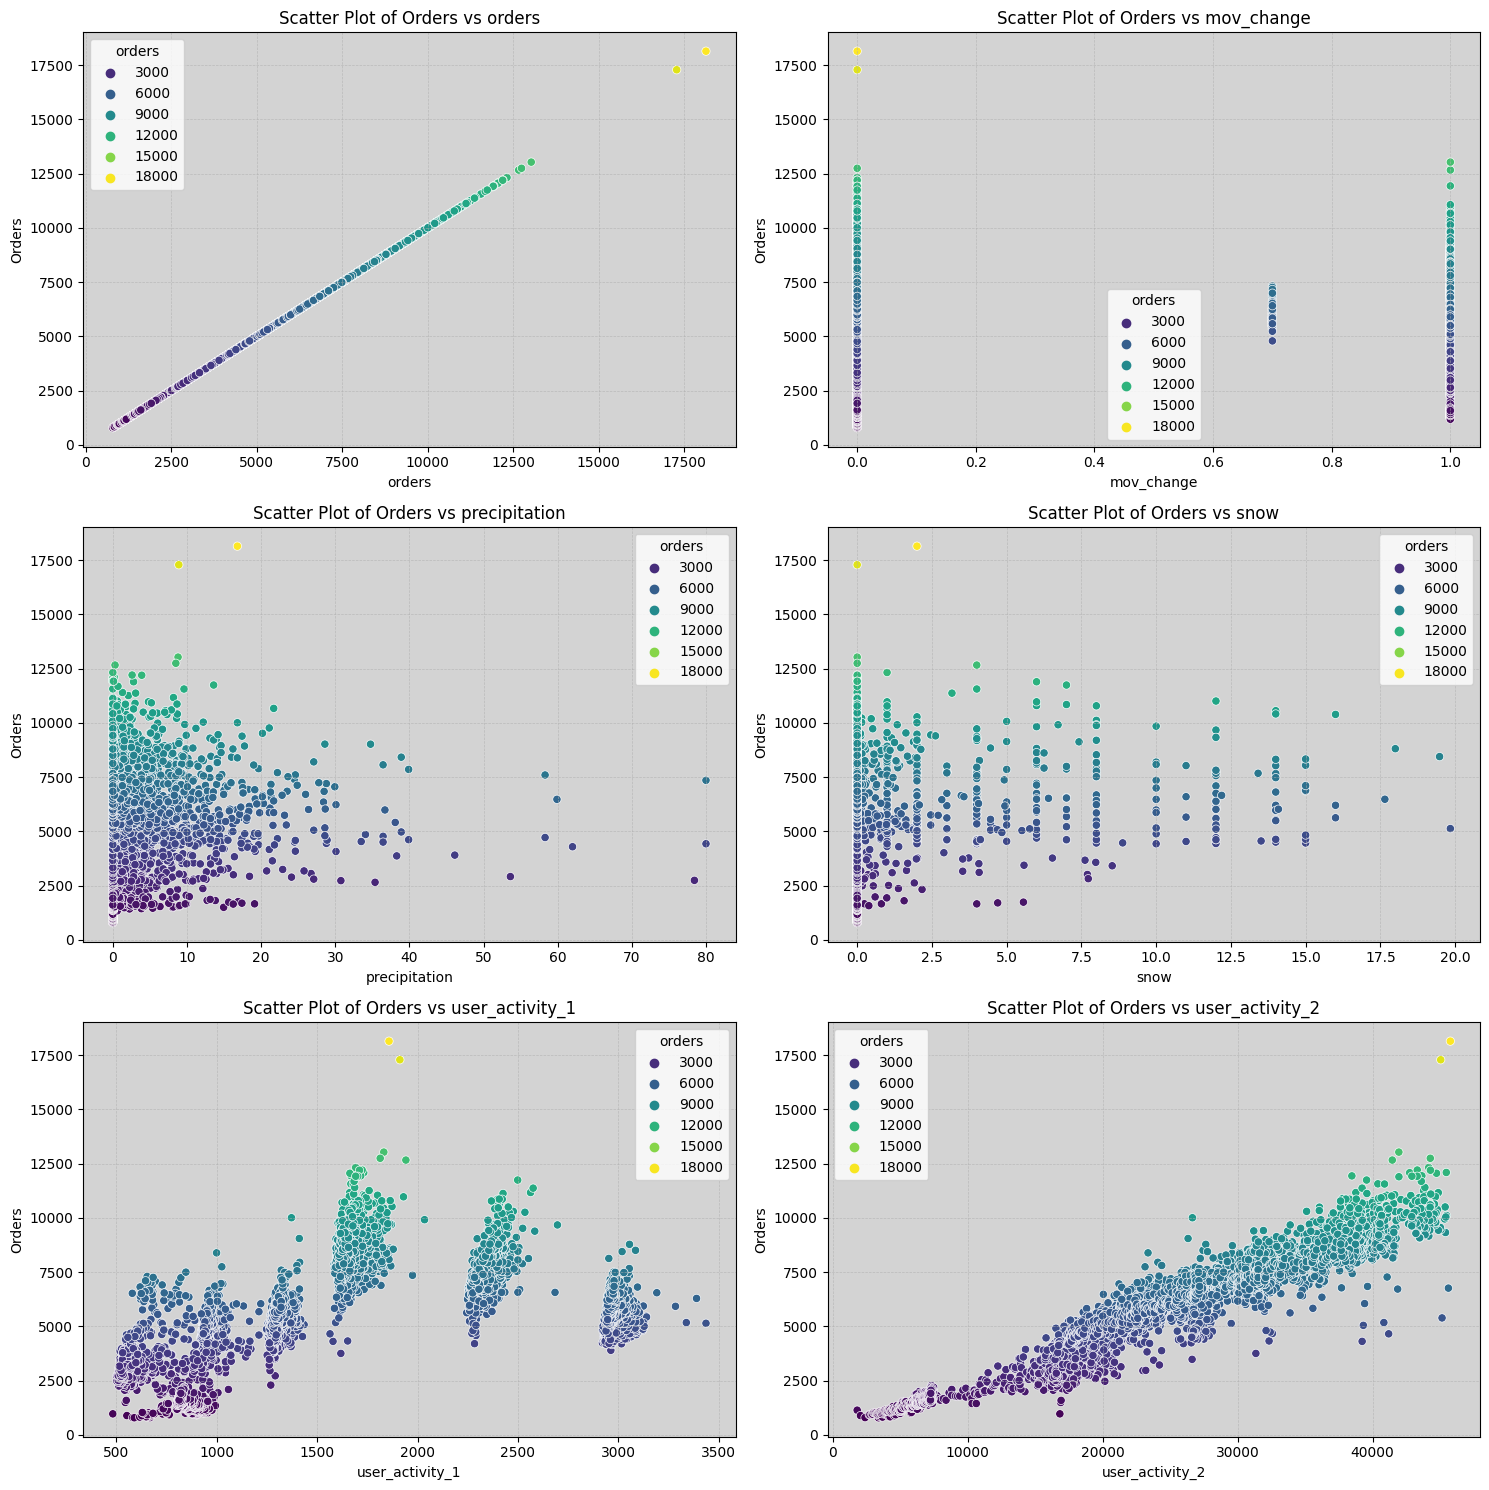

In [21]:
plt.figure(figsize=(15, 15))

# Numerical features to plot
numerical_features = ['orders', 'mov_change', 'precipitation', 'snow', 'user_activity_1', 'user_activity_2']

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    
    # Create the scatter plot
    sns.scatterplot(data=train, x=feature, y='orders',hue = 'orders', palette='viridis')
    
    # Add background color and grid
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.gca().set_facecolor('lightgrey')
    
    # Add titles and labels
    plt.title(f'Scatter Plot of Orders vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Orders')

plt.tight_layout()
plt.show()


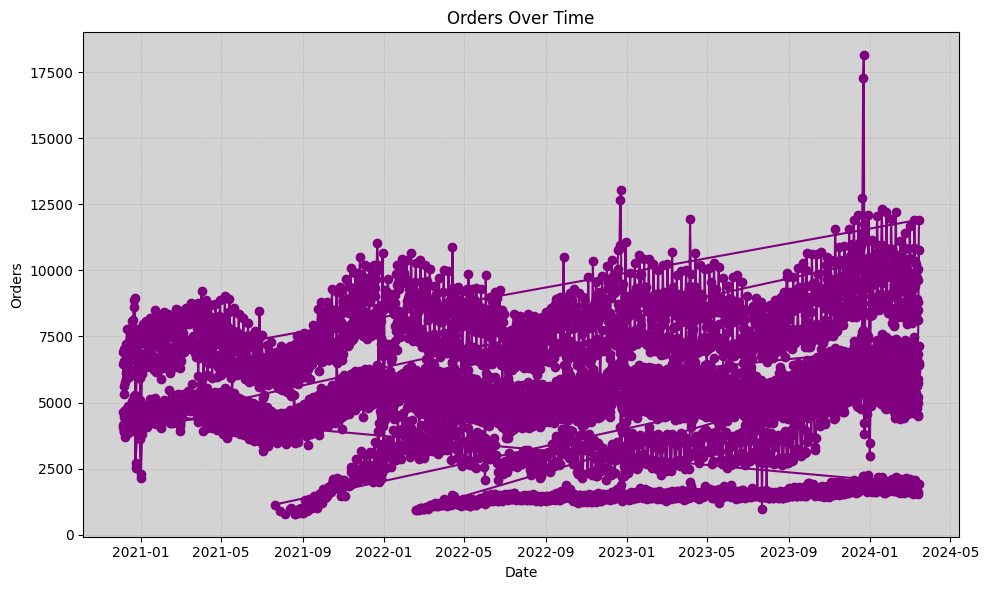

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot orders over time
plt.figure(figsize=(10, 6))

# Ensure 'date' column is in datetime format
train['date'] = pd.to_datetime(train['date'])

plt.plot(train['date'], train['orders'], marker='o', linestyle='-', color='purple')

# Add background color and grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().set_facecolor('lightgrey')

# Add titles and labels
plt.title('Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Orders')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


* Count Plots: Show the distribution of orders for categorical features.
* Box Plots: Display the distribution of orders across different categories.
* Scatter Plots: Reveal relationships between numerical features and orders.
* Time-Series Plot: Visualizes how orders change over time.

# 5.1 Univariate Plot 

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7340 entries, Prague_1_2020-12-05 to Budapest_1_2024-03-14
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   warehouse               7340 non-null   object        
 1   date                    7340 non-null   datetime64[ns]
 2   orders                  7340 non-null   float64       
 3   holiday_name            7340 non-null   object        
 4   holiday                 7340 non-null   int64         
 5   shutdown                7340 non-null   int64         
 6   mini_shutdown           7340 non-null   int64         
 7   shops_closed            7340 non-null   int64         
 8   winter_school_holidays  7340 non-null   int64         
 9   school_holidays         7340 non-null   int64         
 10  blackout                7340 non-null   int64         
 11  mov_change              7340 non-null   float64       
 12  frankfurt_shutdown

In [24]:
# Check for any remaining infinite values
print(train.isin([np.inf, -np.inf]).sum())


warehouse                 0
date                      0
orders                    0
holiday_name              0
holiday                   0
shutdown                  0
mini_shutdown             0
shops_closed              0
winter_school_holidays    0
school_holidays           0
blackout                  0
mov_change                0
frankfurt_shutdown        0
precipitation             0
snow                      0
user_activity_1           0
user_activity_2           0
date_year                 0
date_month                0
week_of_year              0
date_day_of_week          0
date_day                  0
date_hour                 0
dtype: int64


In [25]:
pip install --upgrade pandas seaborn matplotlib


   25l   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/294.9 kB ? eta -:--:--━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 286.7/294.9 kB 12.5 MB/s eta 0:00:01━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.0 MB/s eta 0:00:00
   25l   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/8.3 MB ? eta -:--:--━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/8.3 MB 89.4 MB/s eta 0:00:01━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━ 6.2/8.3 MB 87.4 MB/s eta 0:00:01━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 8.3/8.3 MB 87.4 MB/s eta 0:00:01━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 57.4 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.5
    Uninstalling matplotlib-3.7.5:
      Successfully uninstalled matplotlib-3.7.5
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does not currently take into account all th

In [26]:
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


/tmp/ipykernel_33/327841283.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis_palette = cm.get_cmap('viridis', 256)


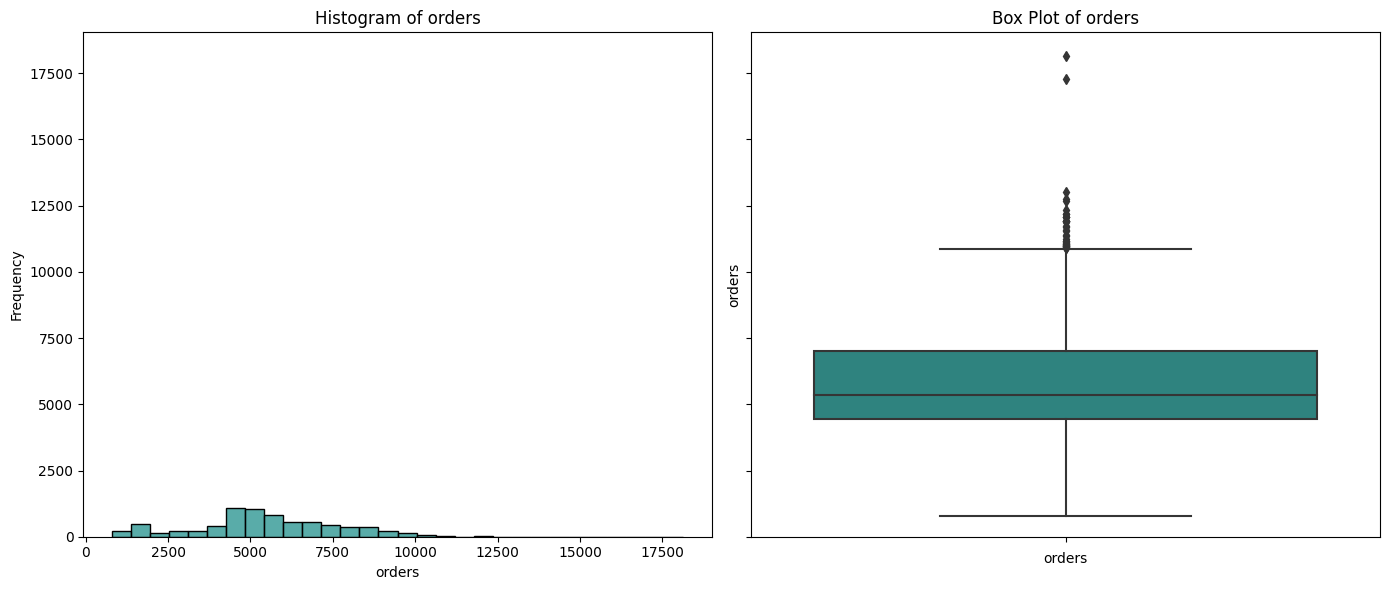

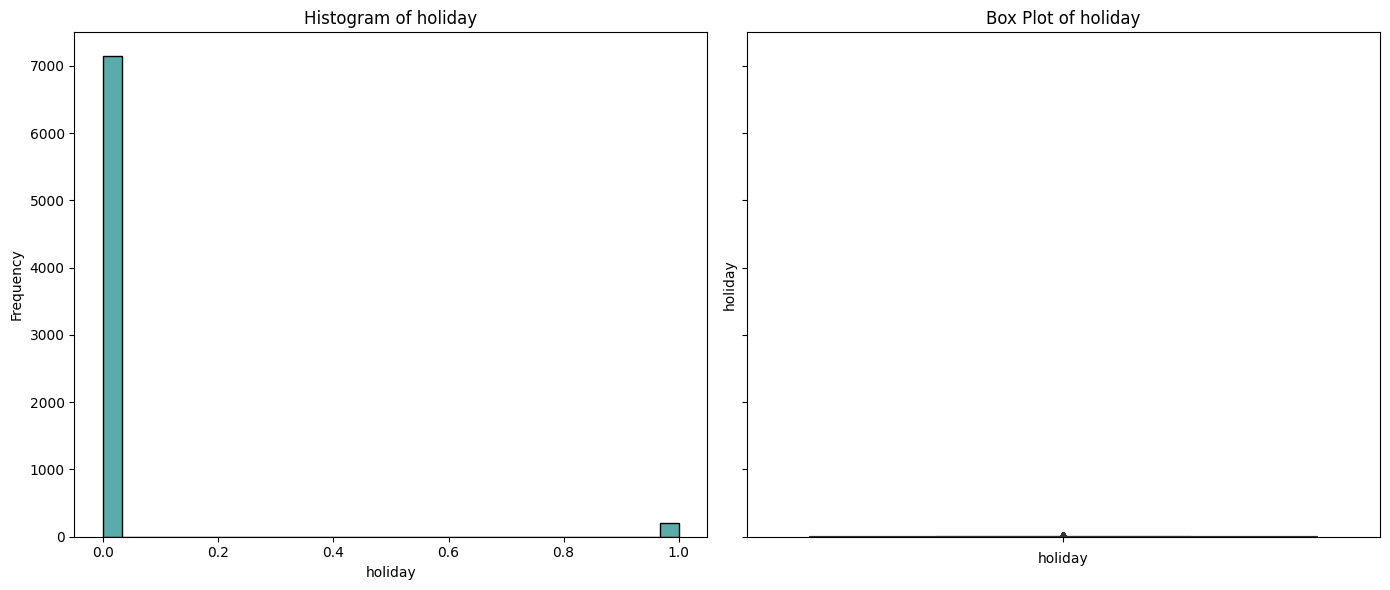

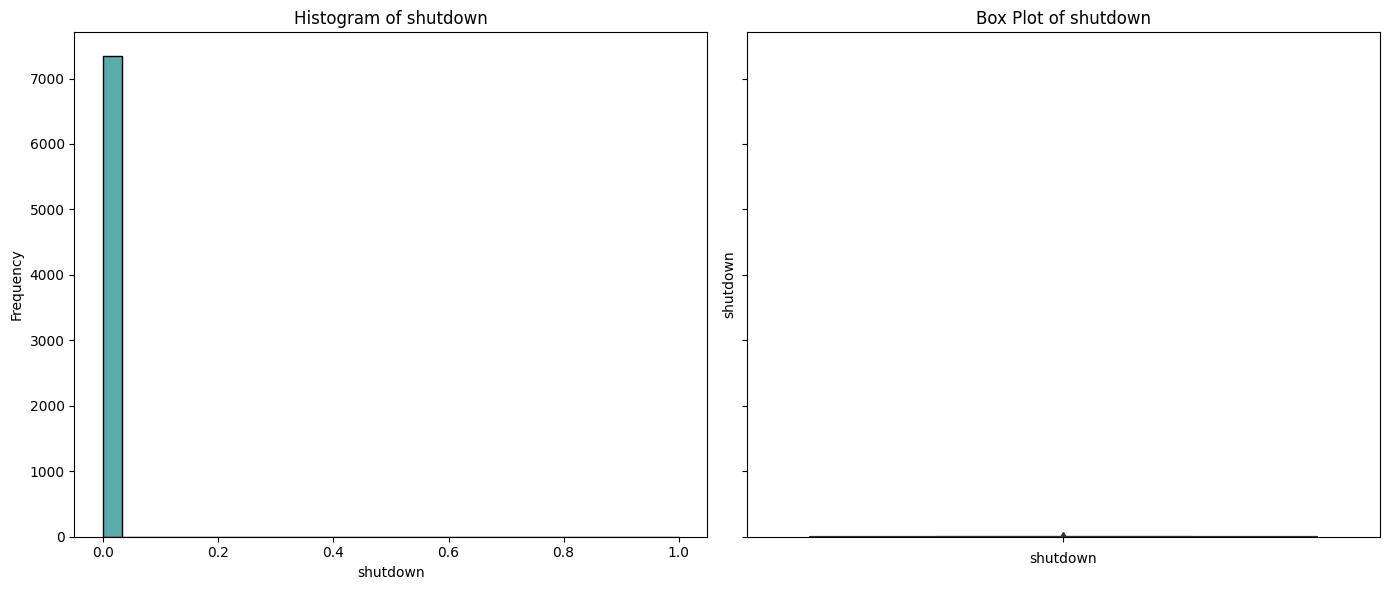

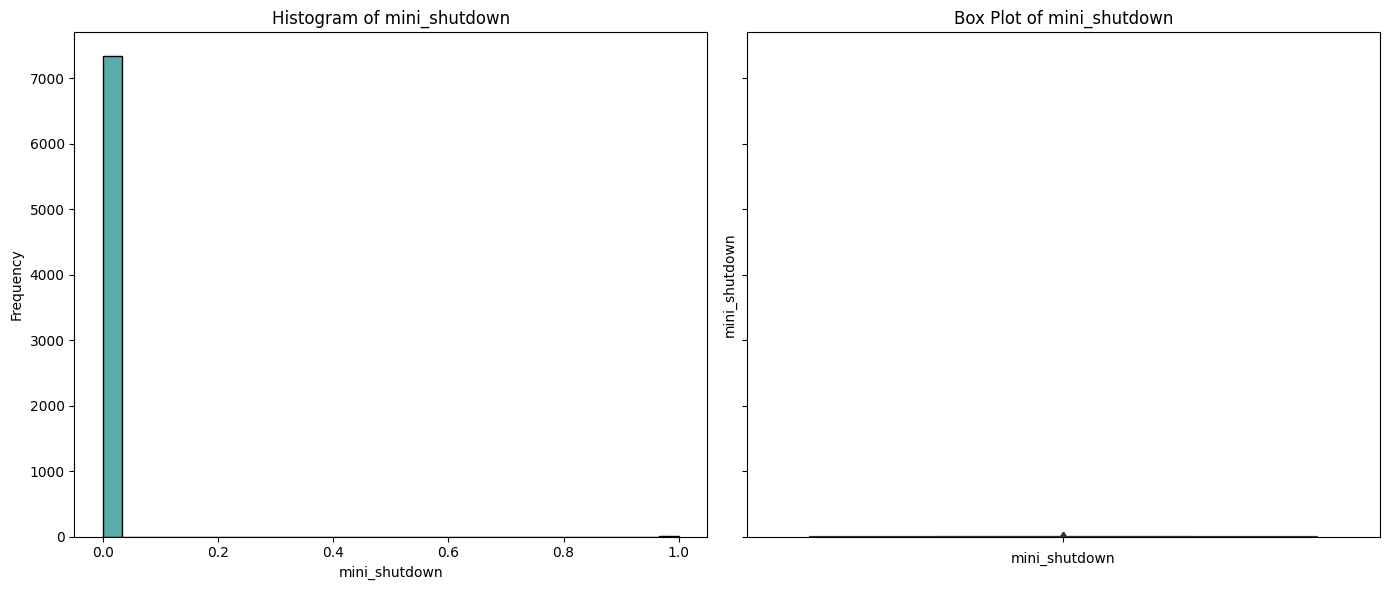

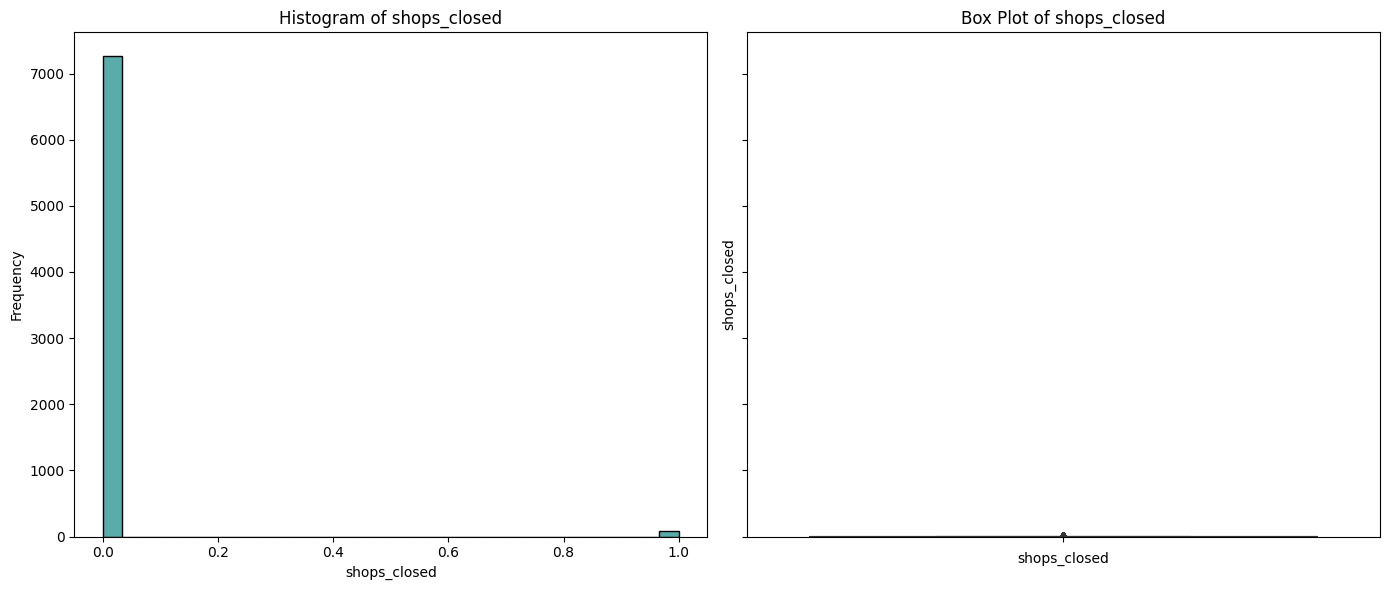

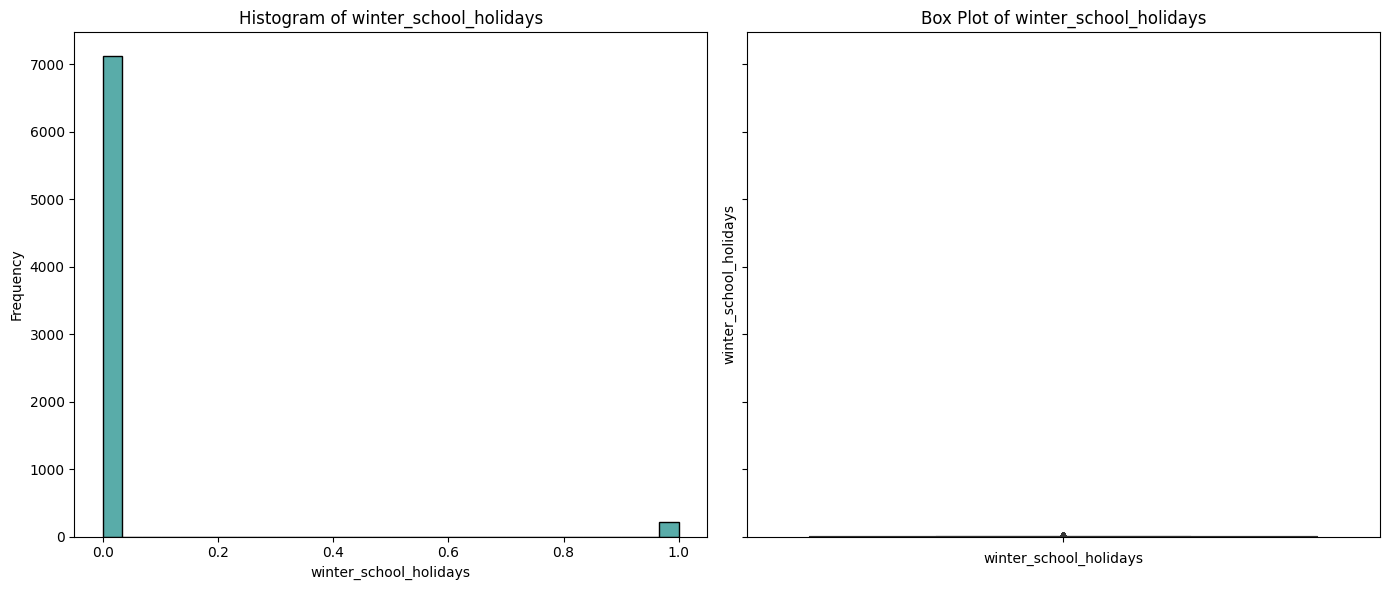

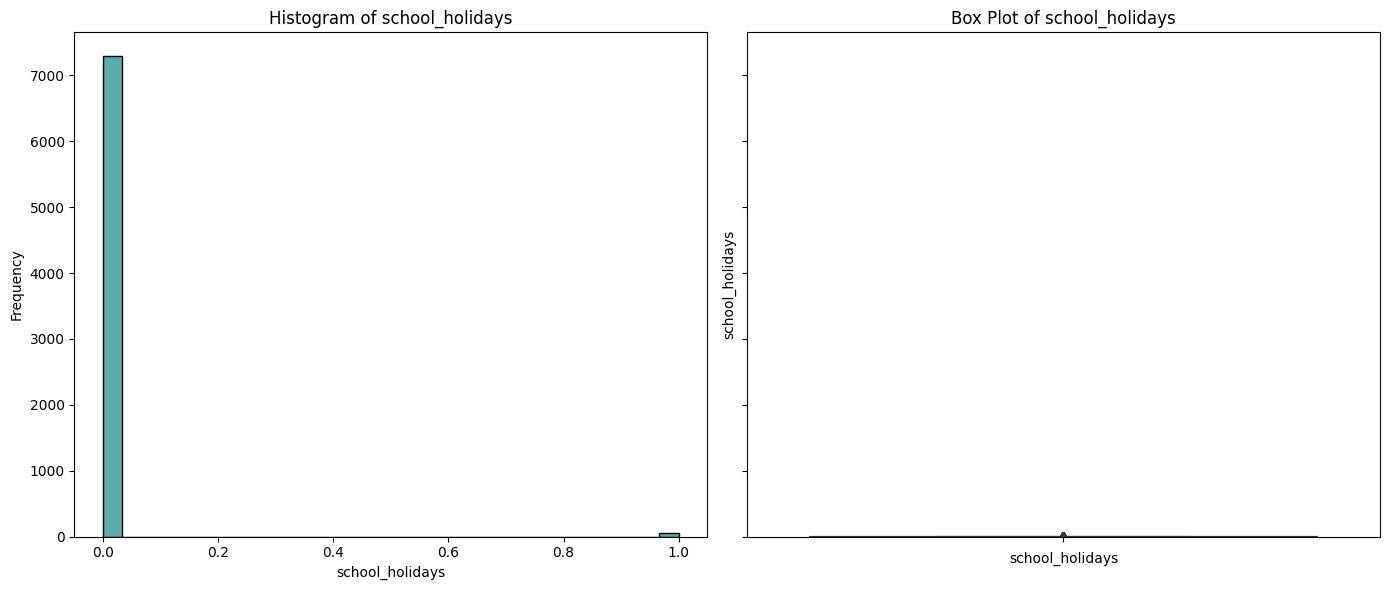

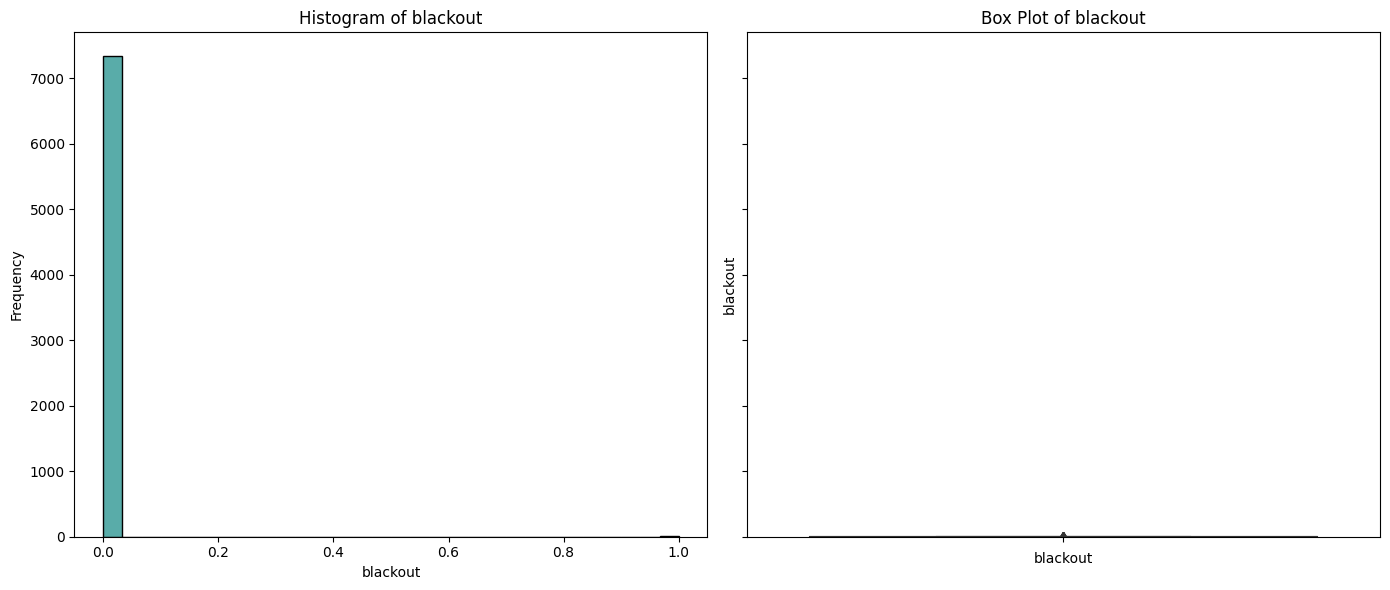

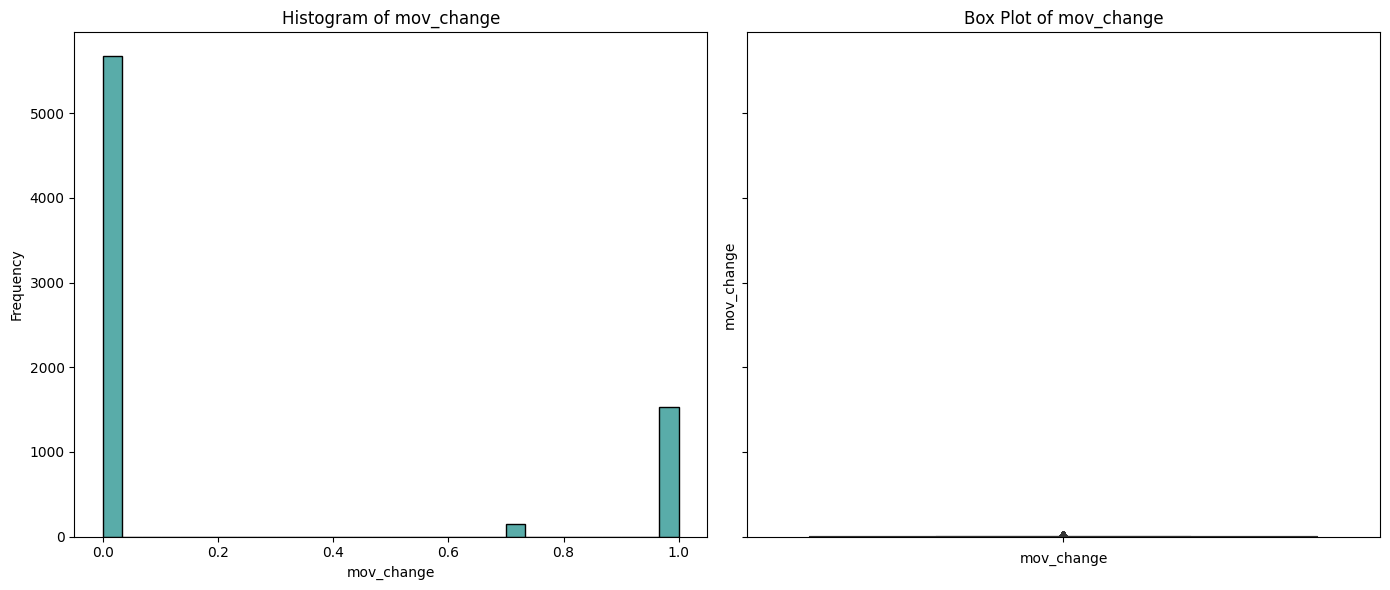

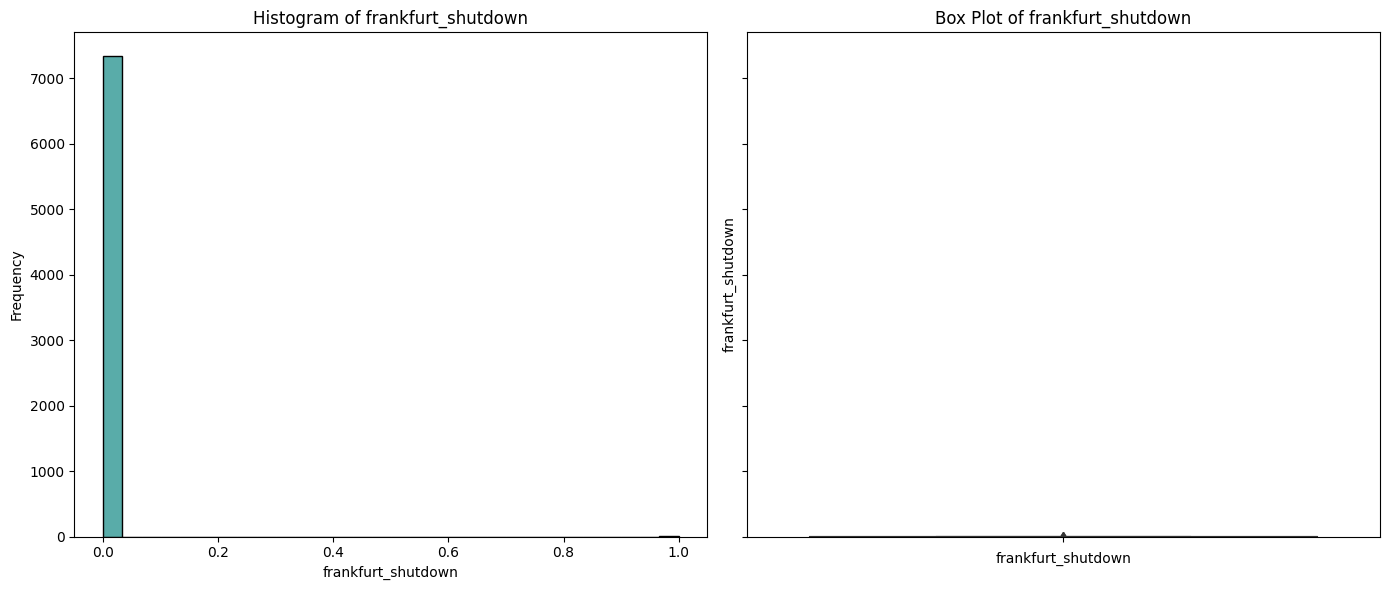

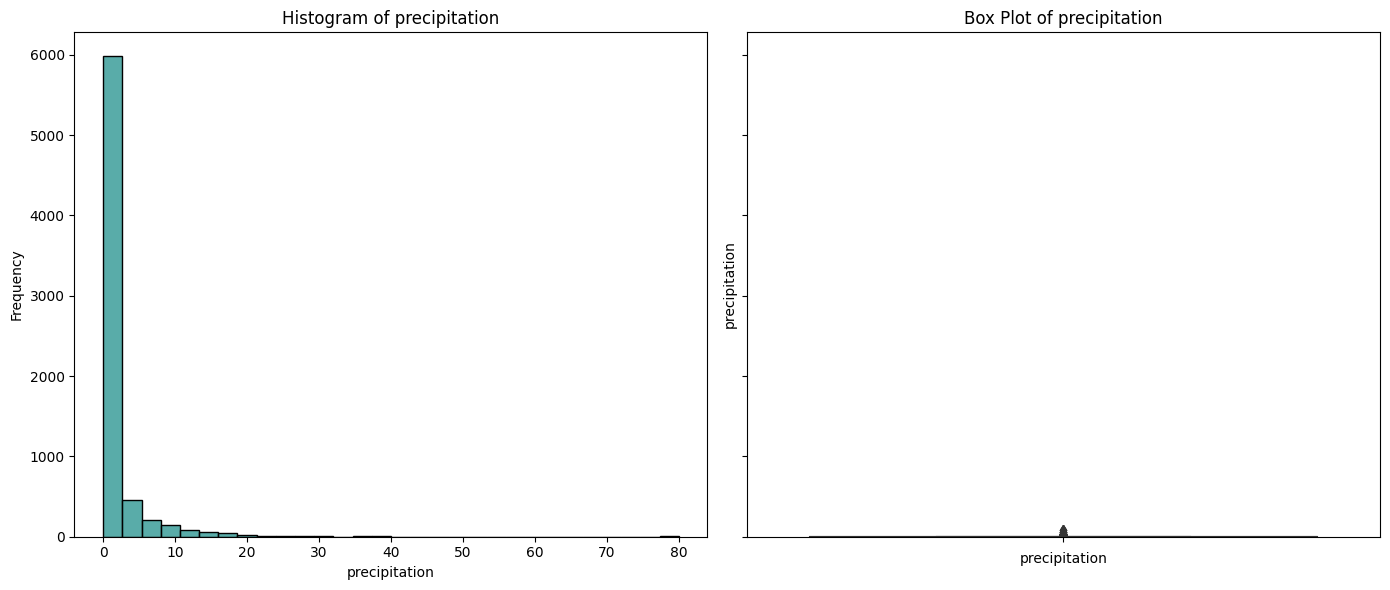

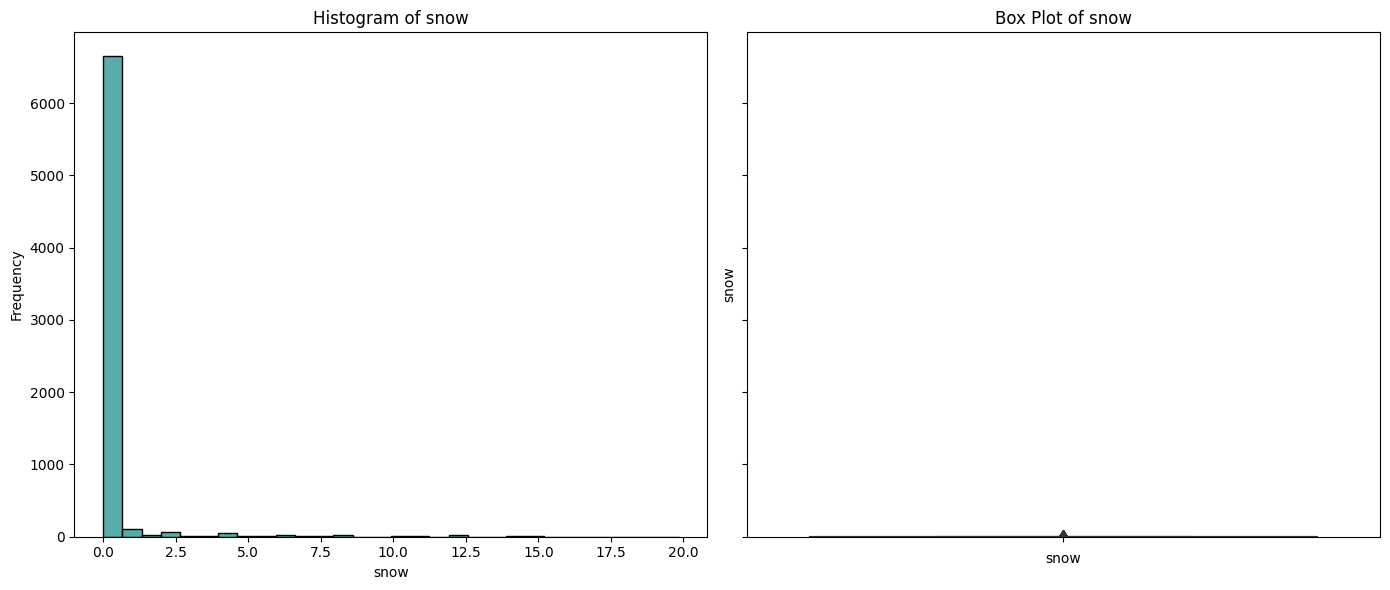

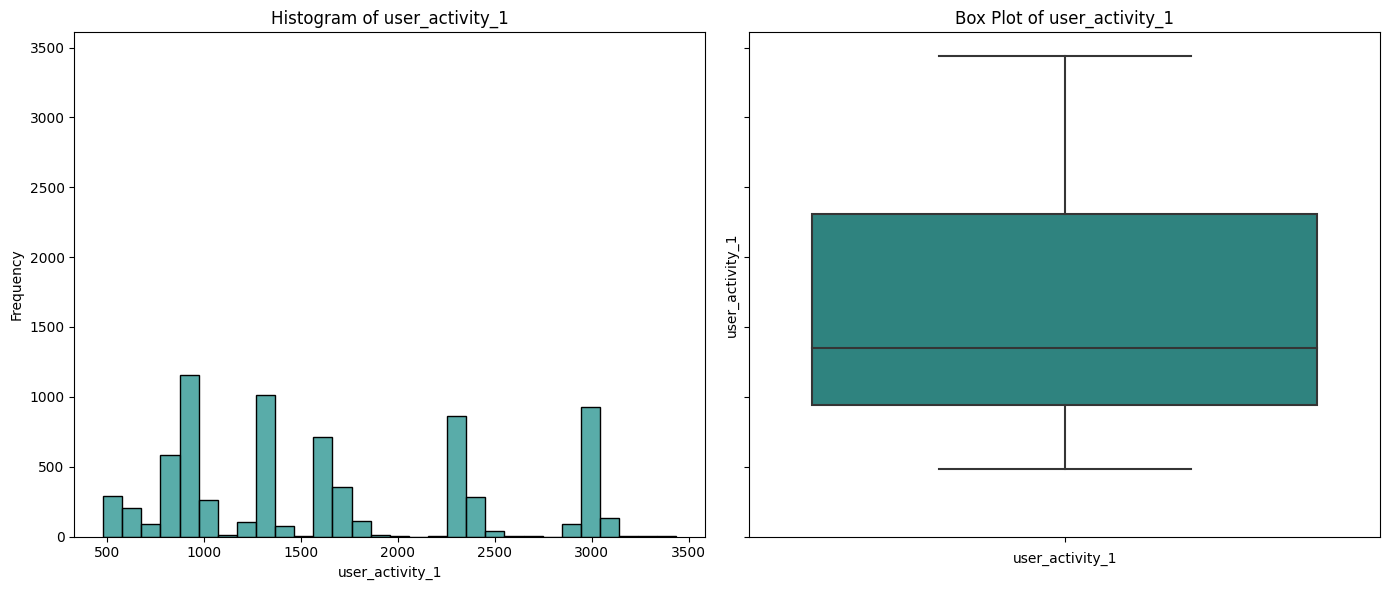

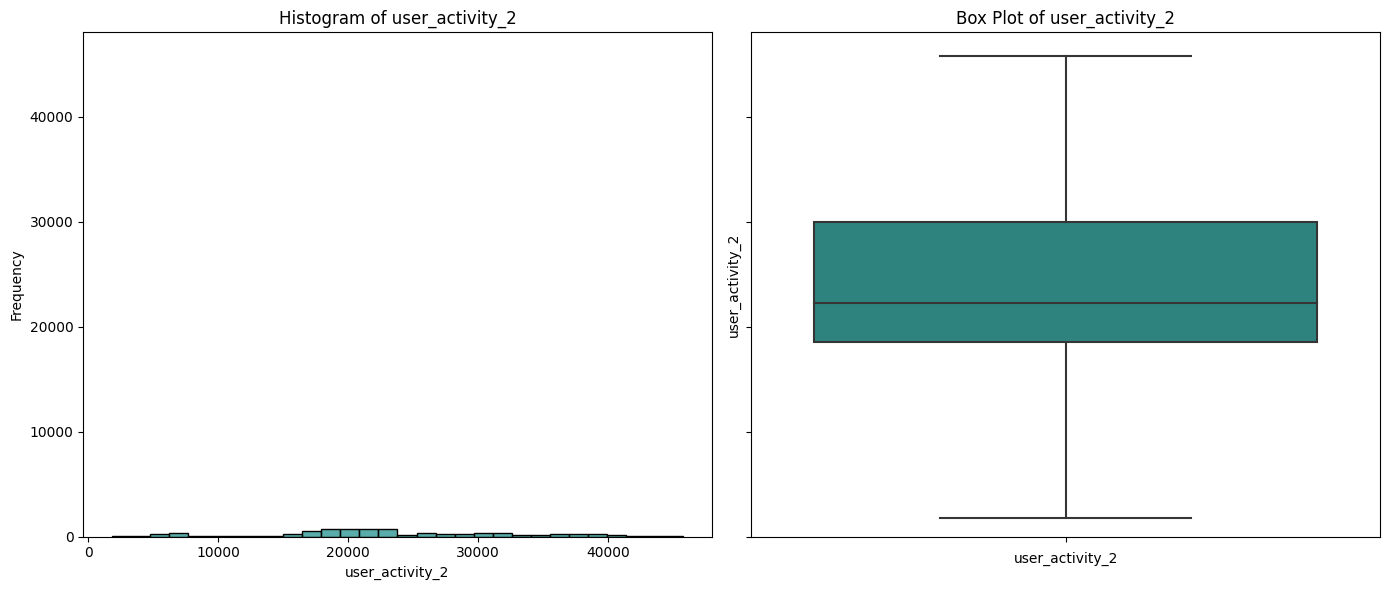

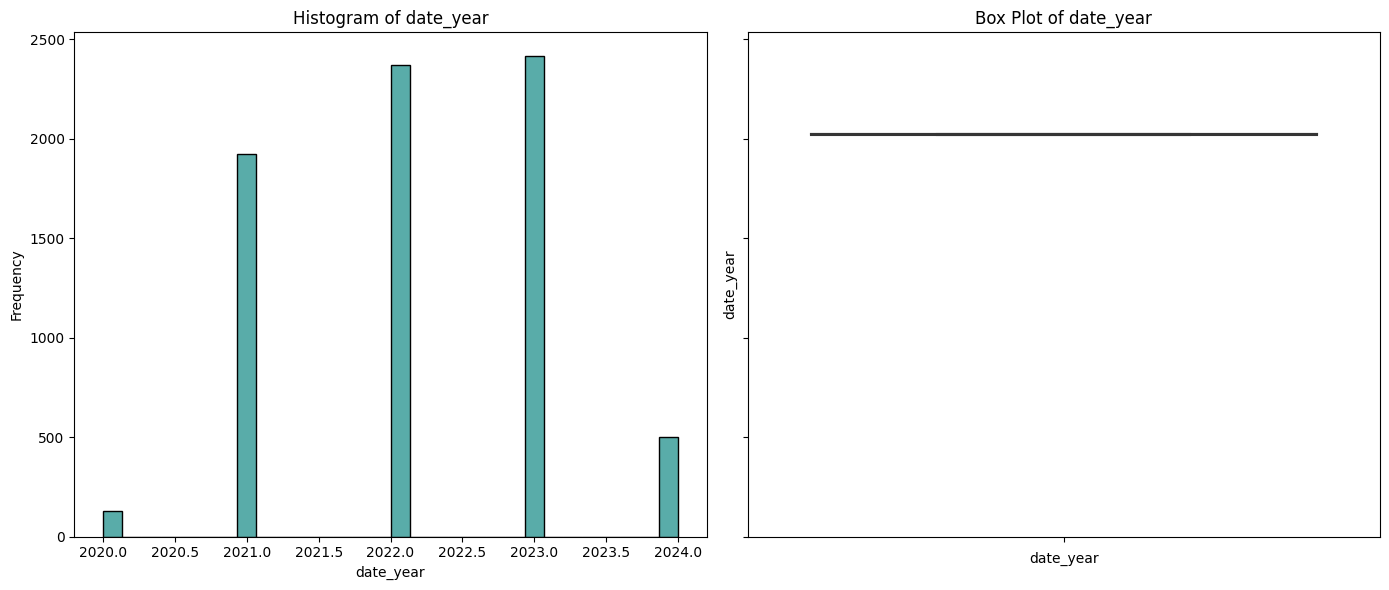

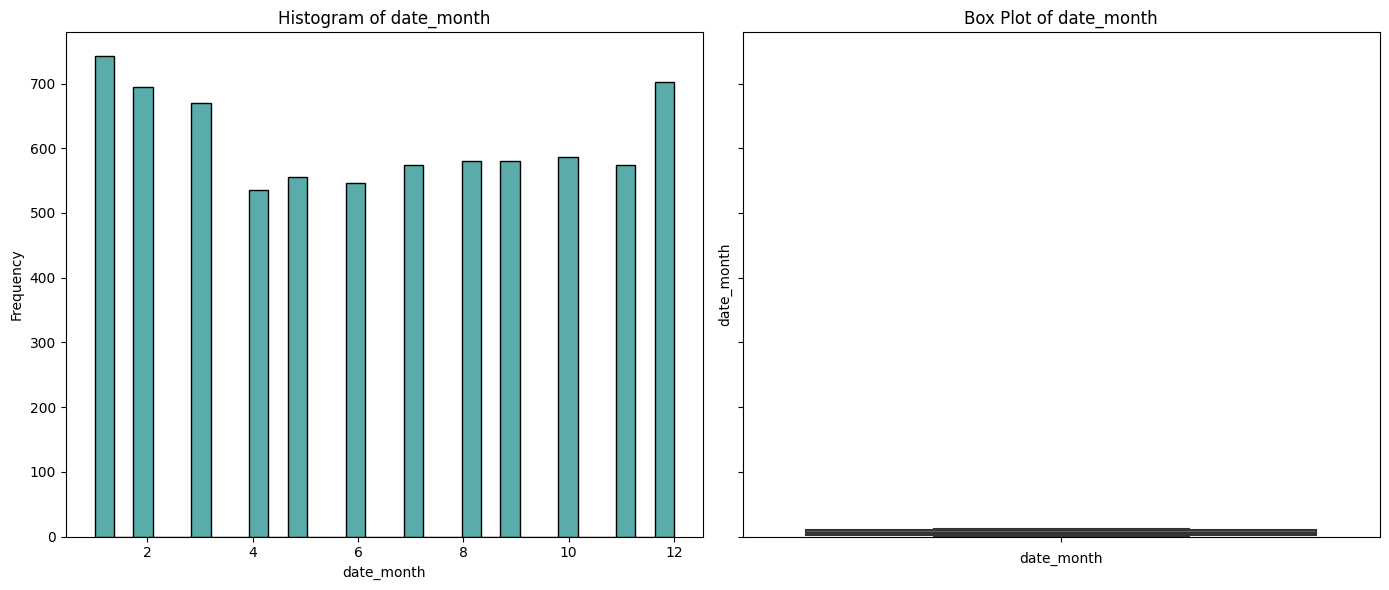

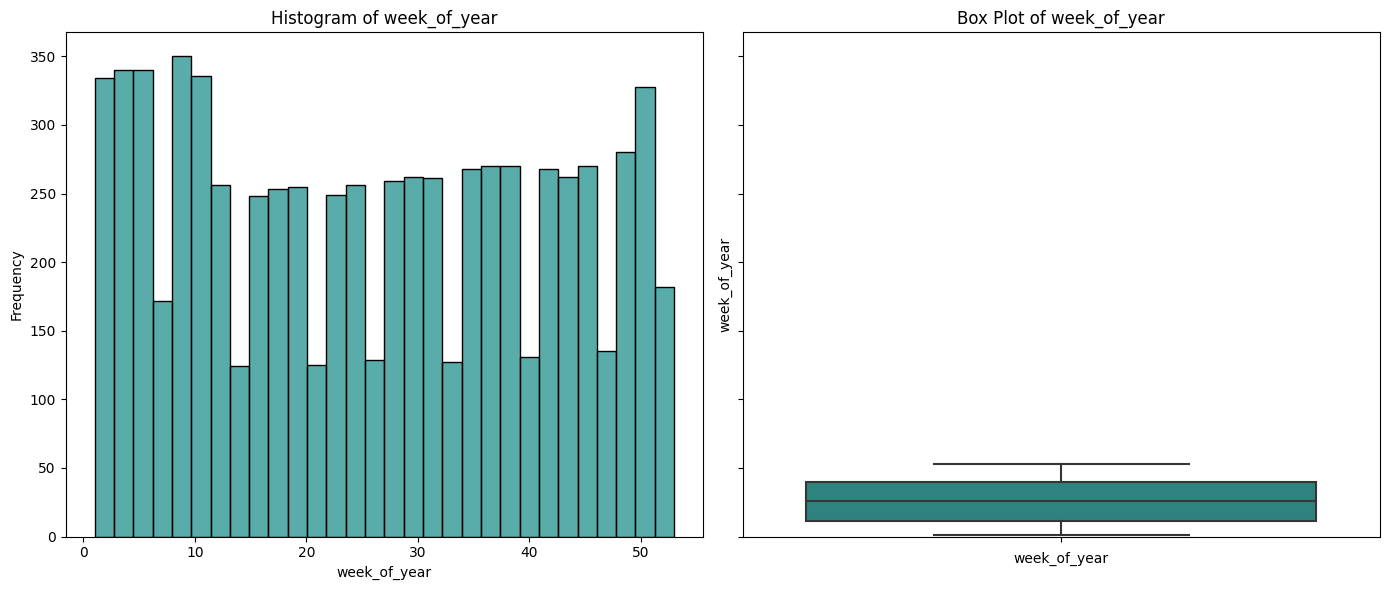

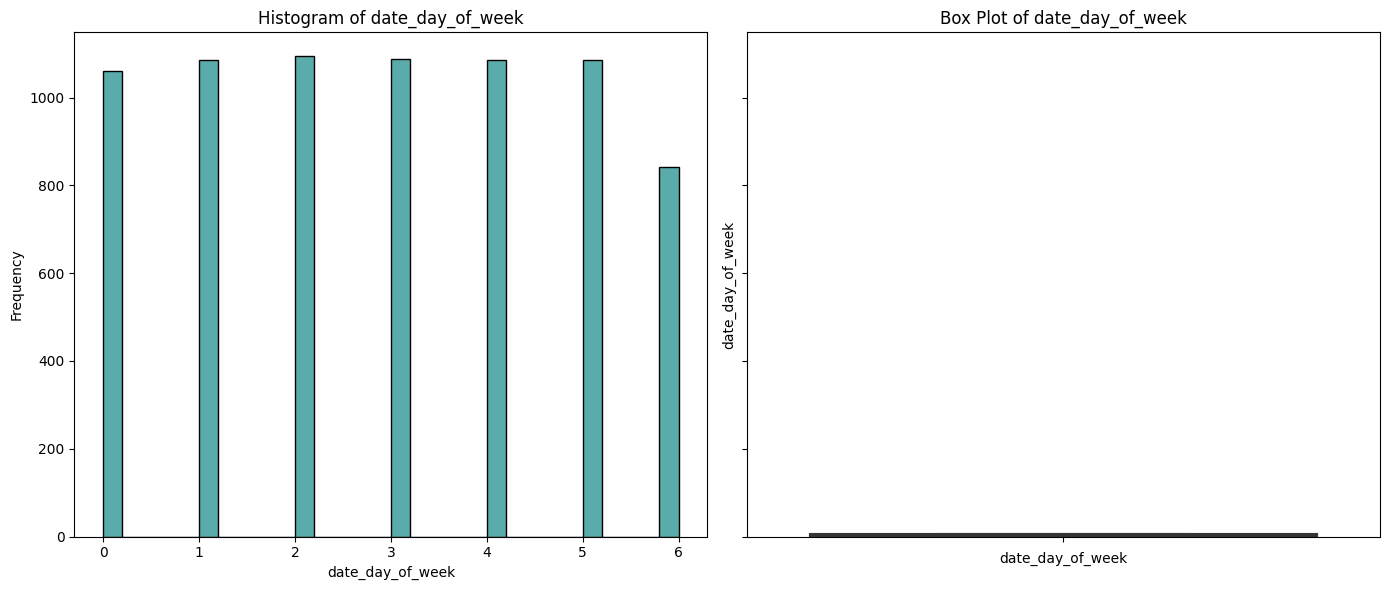

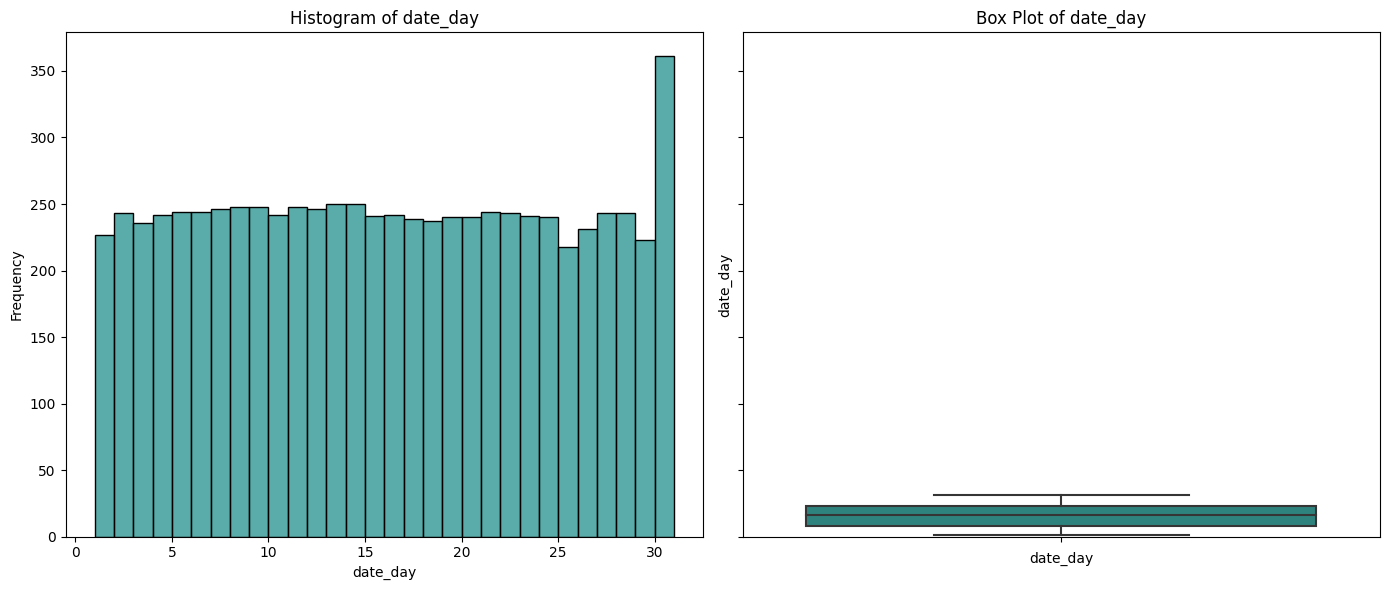

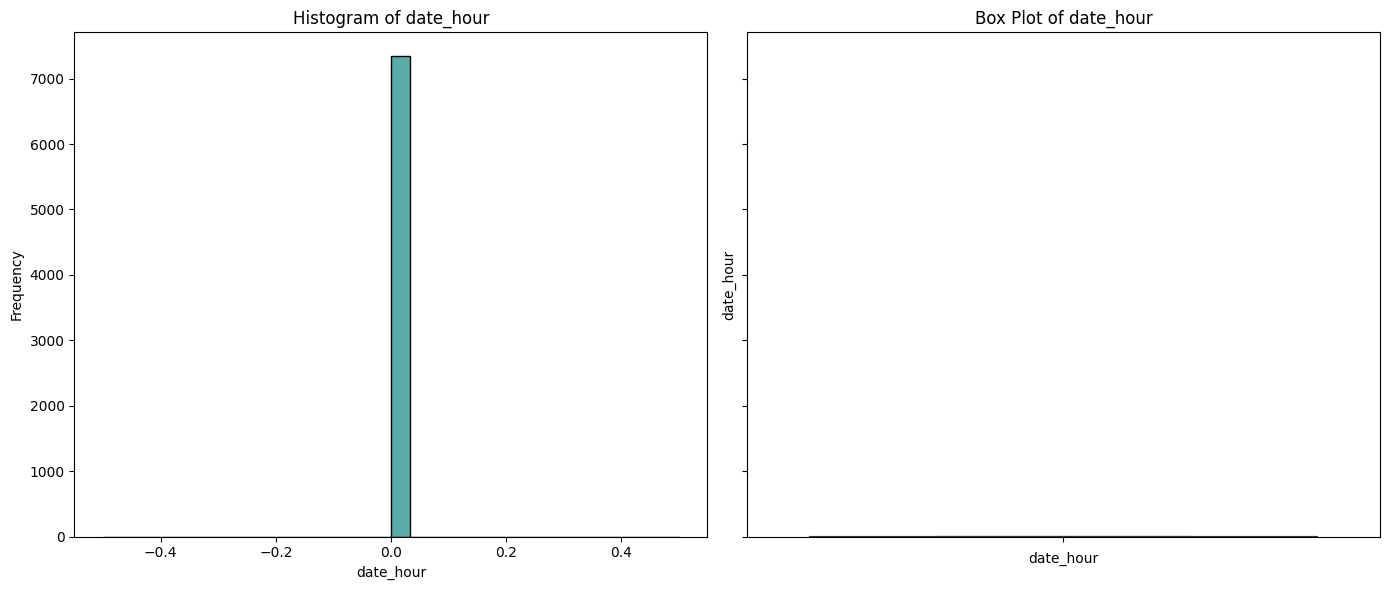

In [27]:

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# Example list of numerical columns for demonstration
# Select numerical columns (float64, int64, int32)
numerical_cols = train.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()

# Create a colormap object with 256 colors
viridis_palette = cm.get_cmap('viridis', 256)  

# Convert the colormap object to a list of colors
viridis_colors = [viridis_palette(i) for i in range(viridis_palette.N)]

# Plot histograms and box plots side by side with viridis color palette
for i, col in enumerate(numerical_cols):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
    # Histogram with viridis palette
    sns.histplot(train[col].dropna(), kde=False, bins=30, ax=axs[0], color=viridis_colors[128])  # Use a mid-range color
    axs[0].set_title(f'Histogram of {col}')
    axs[0].set_xlabel(col)
    axs[0].set_ylabel('Frequency')
    
    # Box Plot with viridis palette
    sns.boxplot(y=train[col], ax=axs[1], color=viridis_colors[128])  # Use the same color for consistency
    axs[1].set_title(f'Box Plot of {col}')
    axs[1].set_xlabel(col)
    
    plt.tight_layout()
    plt.show()  # Ensure plots are displayed


# 5.2 Bivariate Plot

/tmp/ipykernel_33/3493411918.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis_palette = cm.get_cmap('viridis', 256)  # Create a colormap object with 256 colors


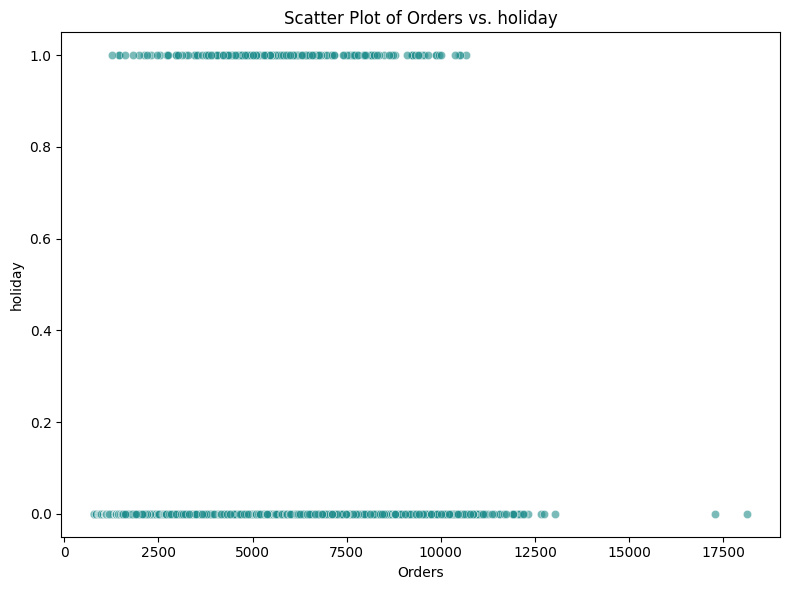

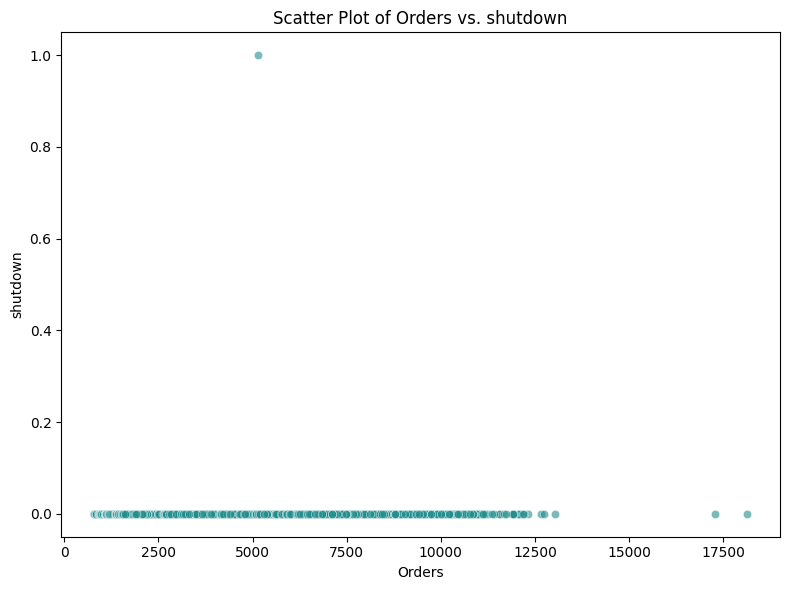

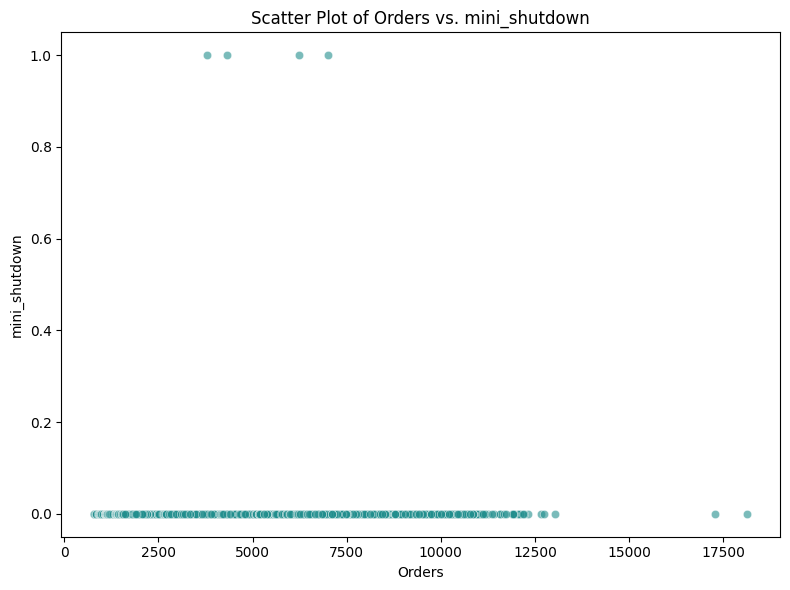

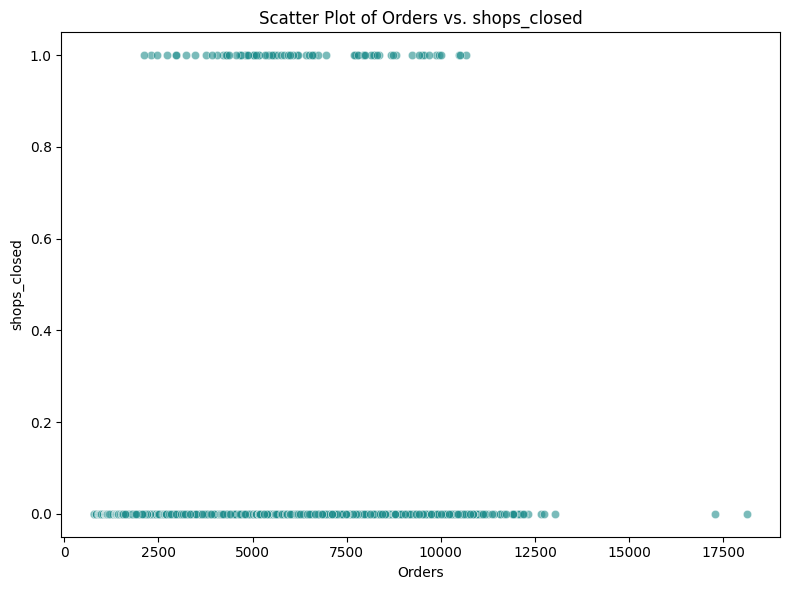

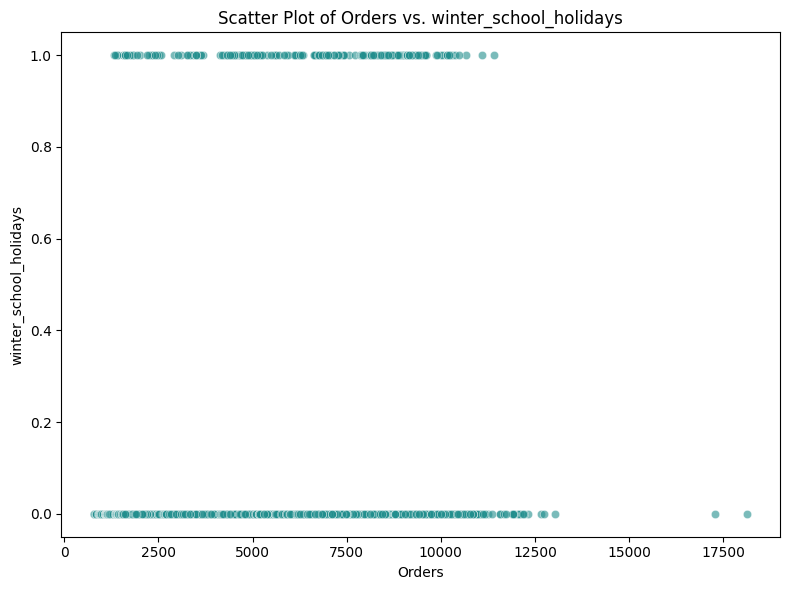

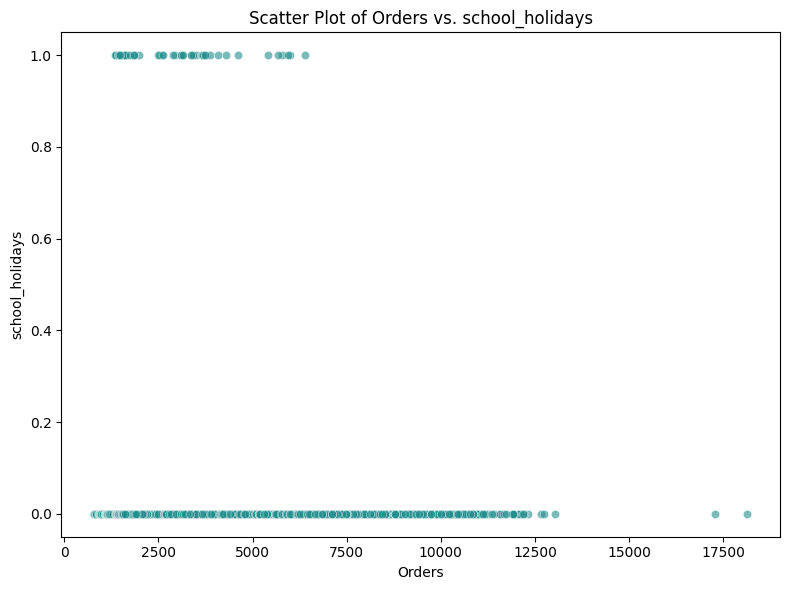

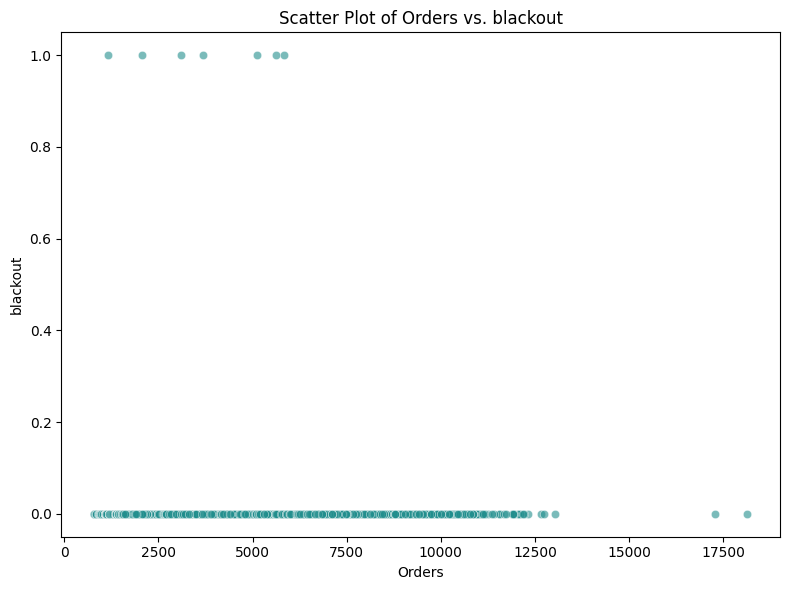

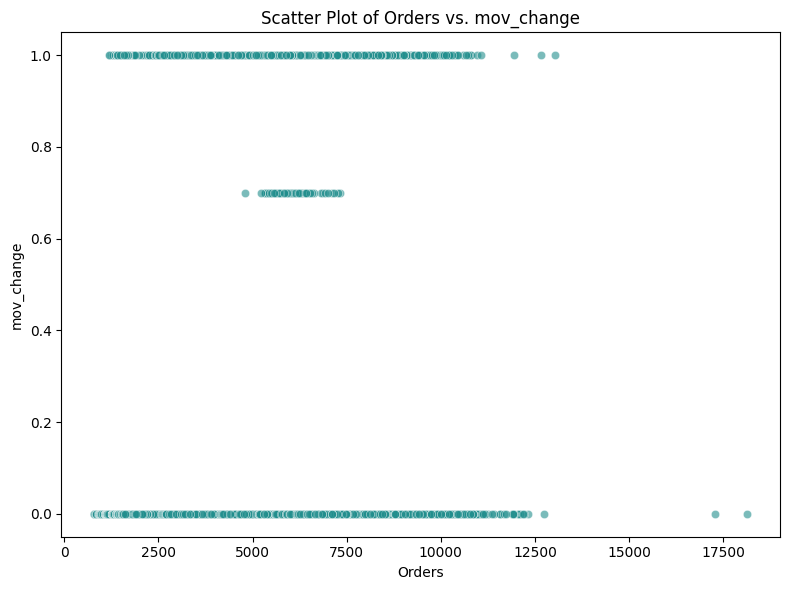

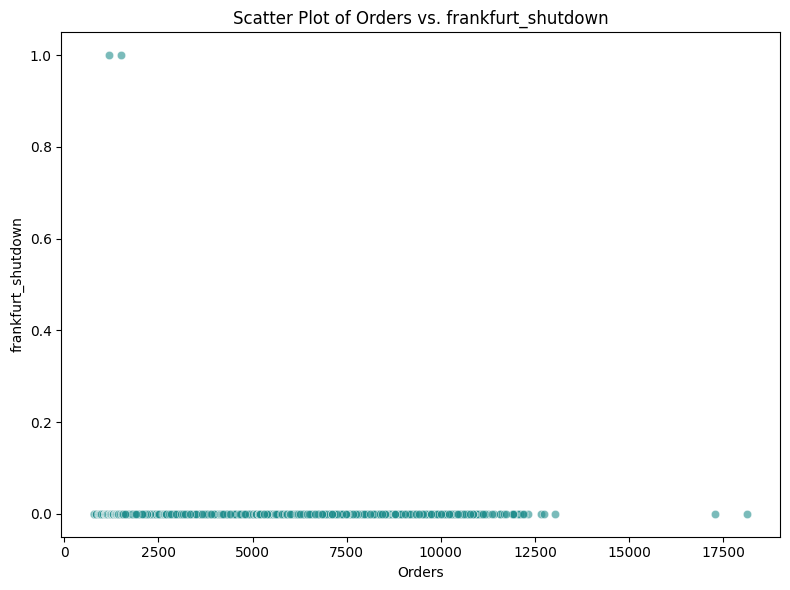

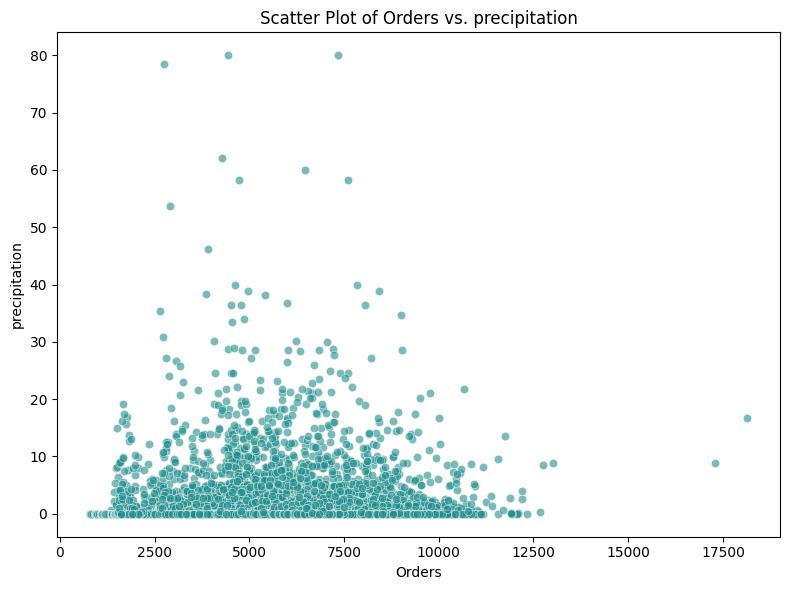

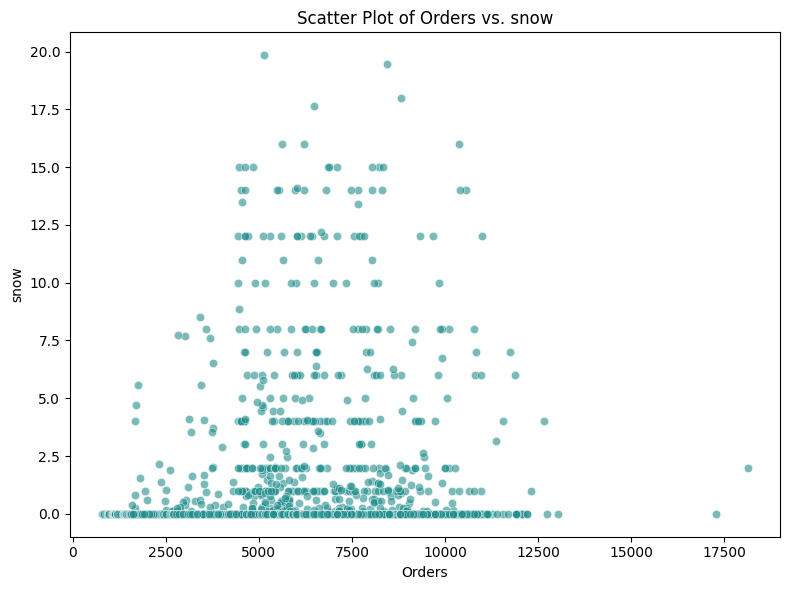

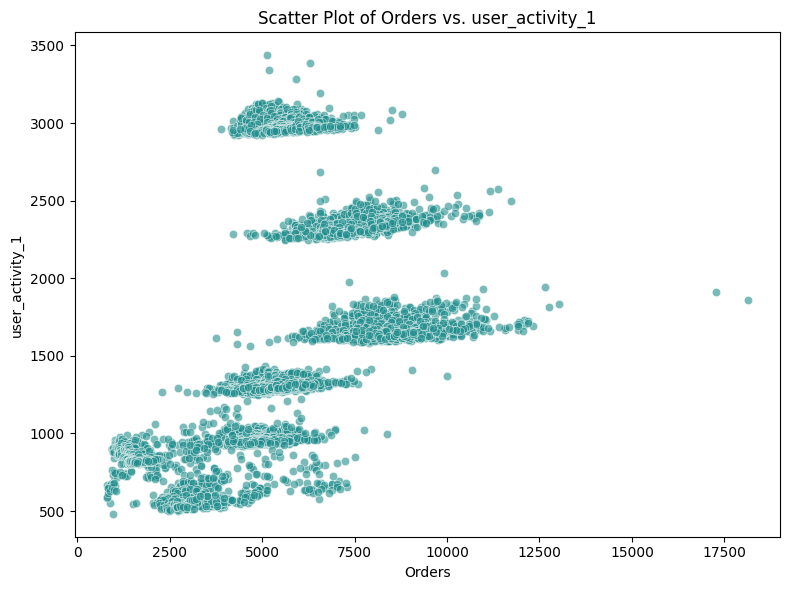

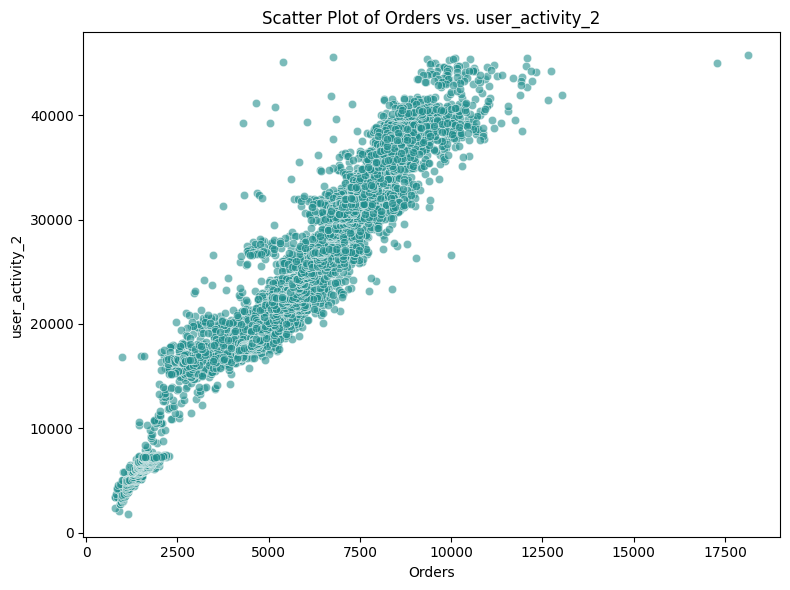

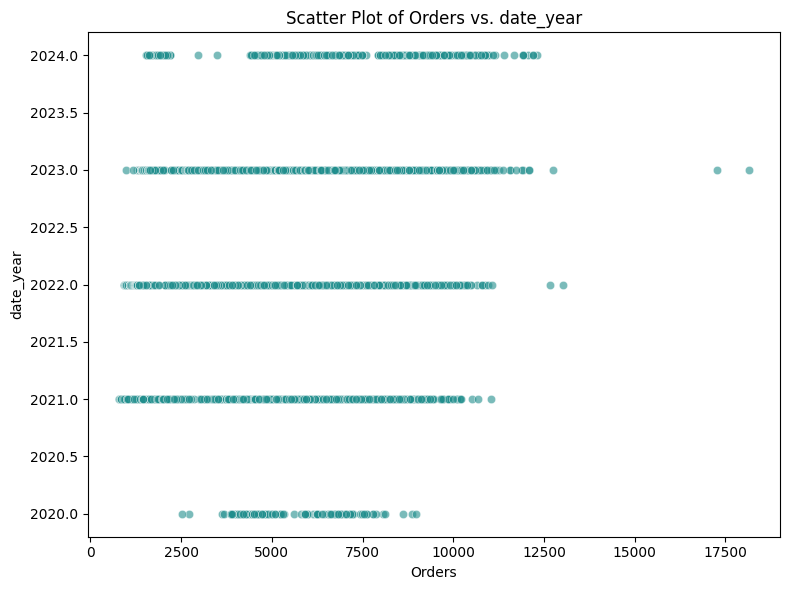

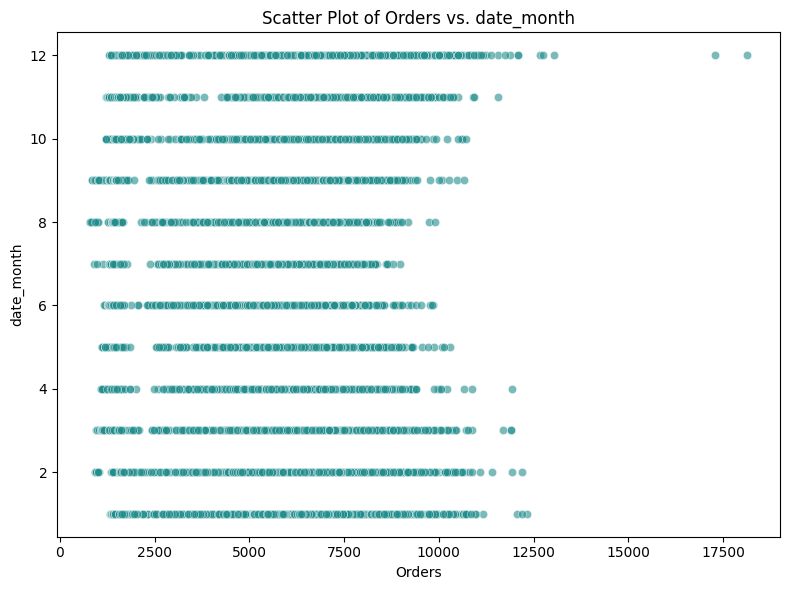

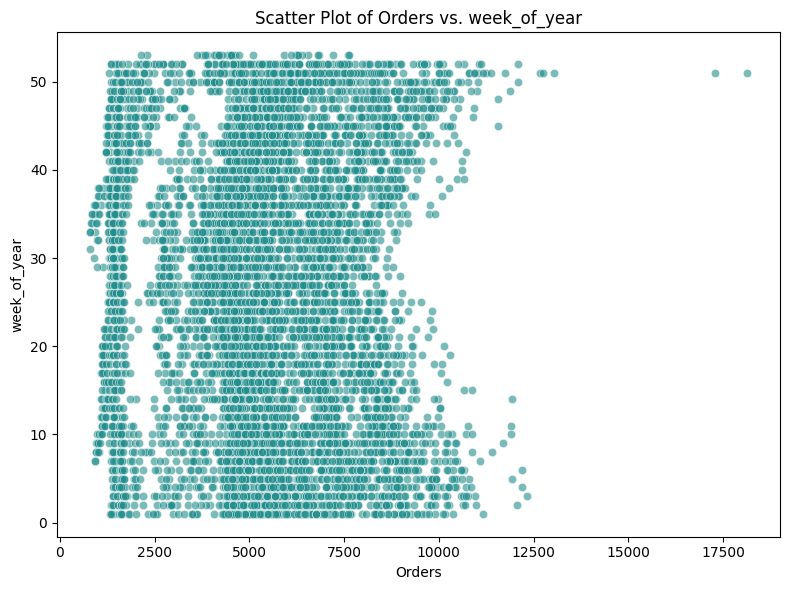

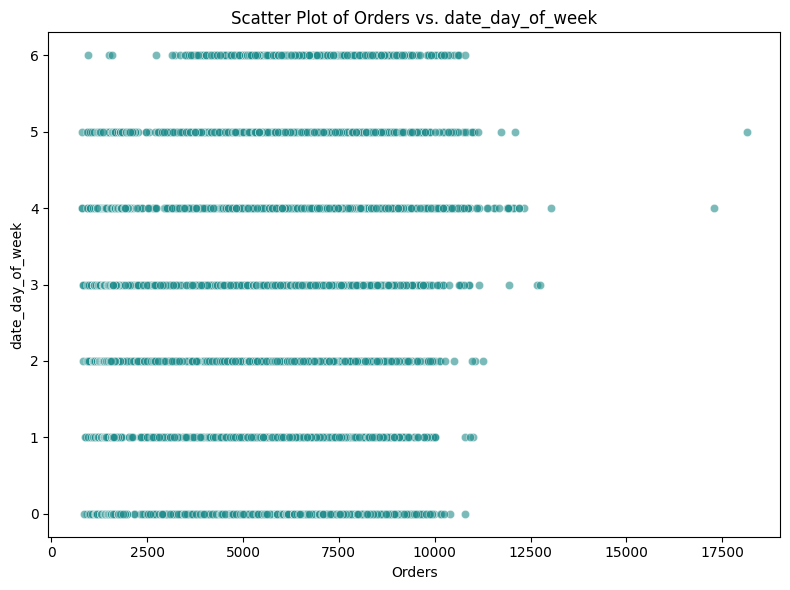

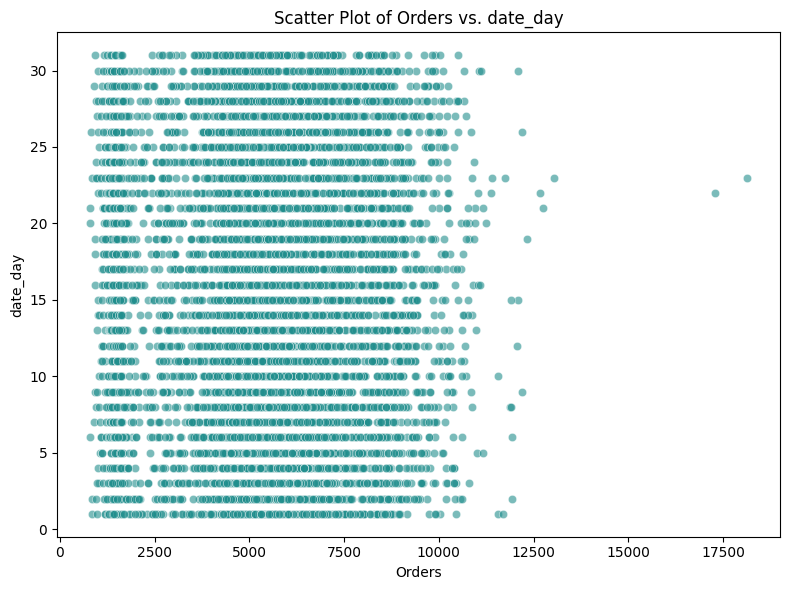

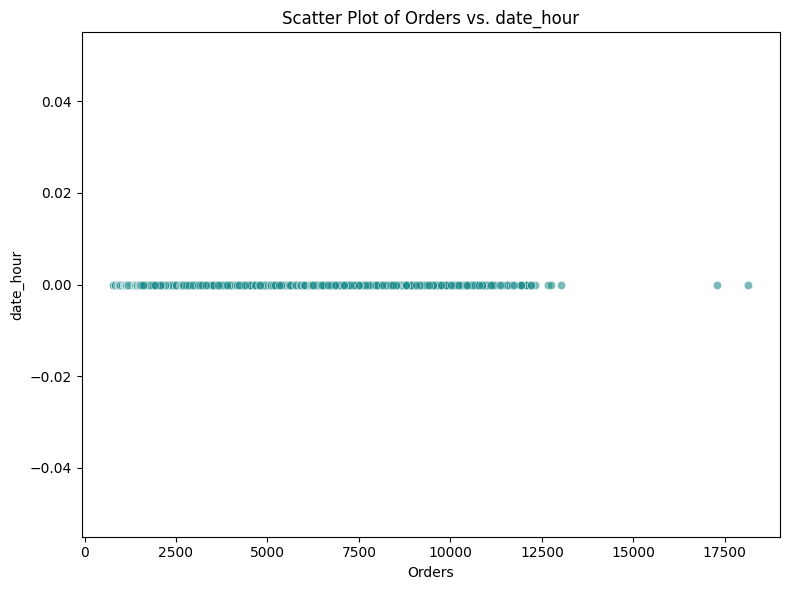

In [28]:
# Replace infinite values with NaN
train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Identify numerical columns excluding 'orders'
numerical_cols = train.select_dtypes(include=['float64', 'int64', 'int32']).columns
numerical_cols = numerical_cols[numerical_cols != 'orders']

# Define the viridis color palette
viridis_palette = cm.get_cmap('viridis', 256)  # Create a colormap object with 256 colors
viridis_palette = [viridis_palette(i) for i in range(viridis_palette.N)]  # Get color values

# Plot for each numerical column against 'orders'
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    
    # Scatter Plot
    sns.scatterplot(x='orders', y=col, data=train, color=viridis_palette[125], alpha=0.6)
    plt.title(f'Scatter Plot of Orders vs. {col}')
    plt.xlabel('Orders')
    plt.ylabel(col)
    
    plt.tight_layout()
    plt.show()

# 5.3  Heat Map

In [29]:
numerical_cols = train.select_dtypes(include=['float64', 'int64', 'int32']).columns
train_numerical = train[numerical_cols]


In [30]:
correlation_matrix = train_numerical.corr()


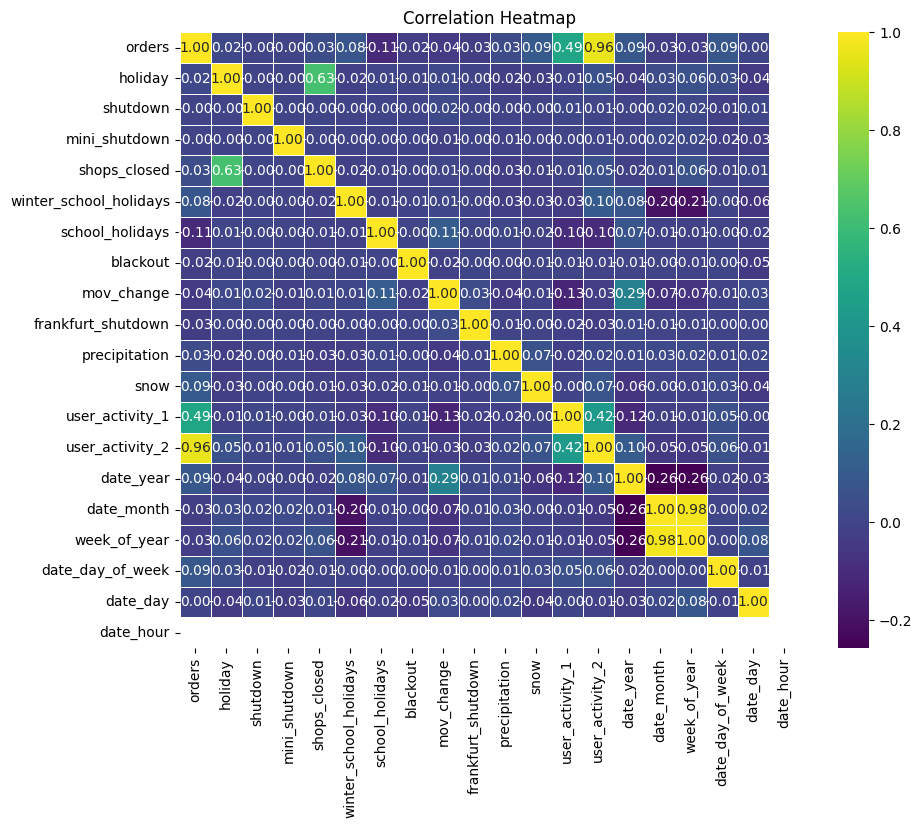

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


# 5.4 Stacked Correlation graph

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


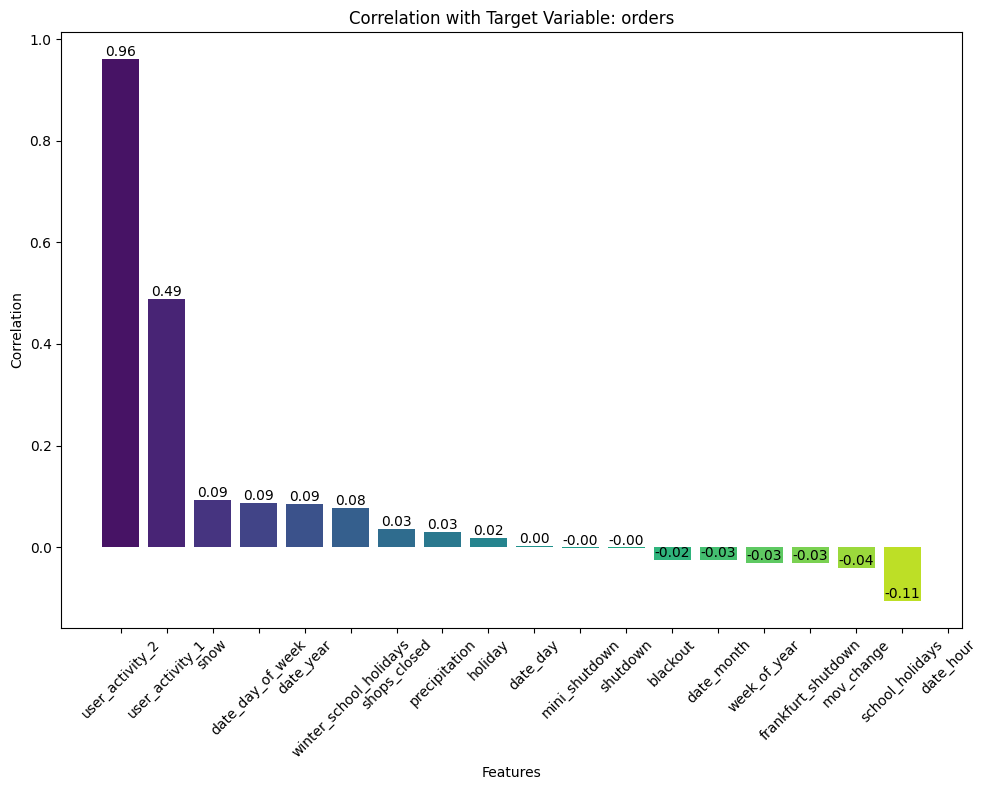

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def correlation_to_target(df, target):
    """
    Plots the correlation of features with the specified target variable.

    Parameters:
    - df: DataFrame containing the features and target variable.
    - target: The target variable to correlate with.

    Returns:
    - None
    """
    # Ensure the target variable is in the DataFrame
    if target not in df.columns:
        raise ValueError(f"The target variable '{target}' is not in the DataFrame columns.")

    # Select numerical columns excluding the target variable
    numerical_cols = df.select_dtypes(include=['float64', 'int64', 'int32']).columns
    if target in numerical_cols:
        numerical_cols = numerical_cols[numerical_cols != target]

    # Compute correlation with the target variable
    correlations = df[numerical_cols].corrwith(df[target])

    # Prepare data for plotting
    plot_data = pd.DataFrame({
        'Feature': correlations.index,
        'Correlation': correlations.values
    }).sort_values(by='Correlation', ascending=False)

    # Plot the bar chart
    plt.figure(figsize=(10, 8))
    bars = plt.bar(plot_data['Feature'], plot_data['Correlation'], color=sns.color_palette('viridis', n_colors=len(plot_data)))
    
    # Add text annotations
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom')

    plt.title(f'Correlation with Target Variable: {target}')
    plt.xlabel('Features')
    plt.ylabel('Correlation')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

target = 'orders'

correlation_to_target(train, target)

In [33]:
pip install scipy


Note: you may need to restart the kernel to use updated packages.


# 5.5 Map Showing the association of different data

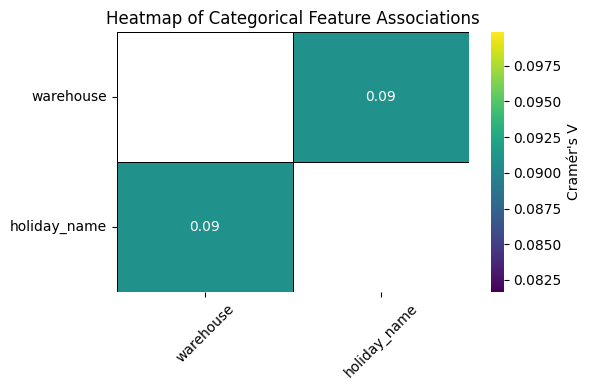

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np

def cramers_v(x, y):
    """
    Compute Cramér's V statistic for association between two categorical variables.
    """
    crosstab = pd.crosstab(x, y)
    chi2_stat = chi2_contingency(crosstab)[0]
    n = crosstab.sum().sum()
    k = min(crosstab.shape) - 1
    return np.sqrt(chi2_stat / (n * k))

def categorical_association_map(df):
    """
    Plot a heatmap of associations between categorical features.
    
    Parameters:
    - df: DataFrame containing categorical features.
    
    Returns:
    - None
    """
    # Select categorical columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns

    # Initialize association matrix
    association_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)
    
    # Compute pairwise associations
    for col1 in cat_cols:
        for col2 in cat_cols:
            if col1 != col2:
                association_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
            else:
                association_matrix.loc[col1, col2] = np.nan

    # Plot heatmap
    plt.figure(figsize=(6,4))
    sns.heatmap(association_matrix.astype(float), annot=True, cmap='viridis', fmt='.2f', 
                linewidths=0.5, linecolor='black', cbar_kws={'label': 'Cramér\'s V'})
    plt.title('Heatmap of Categorical Feature Associations')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


categorical_association_map(df)


# 5.6 Trend Line Plot

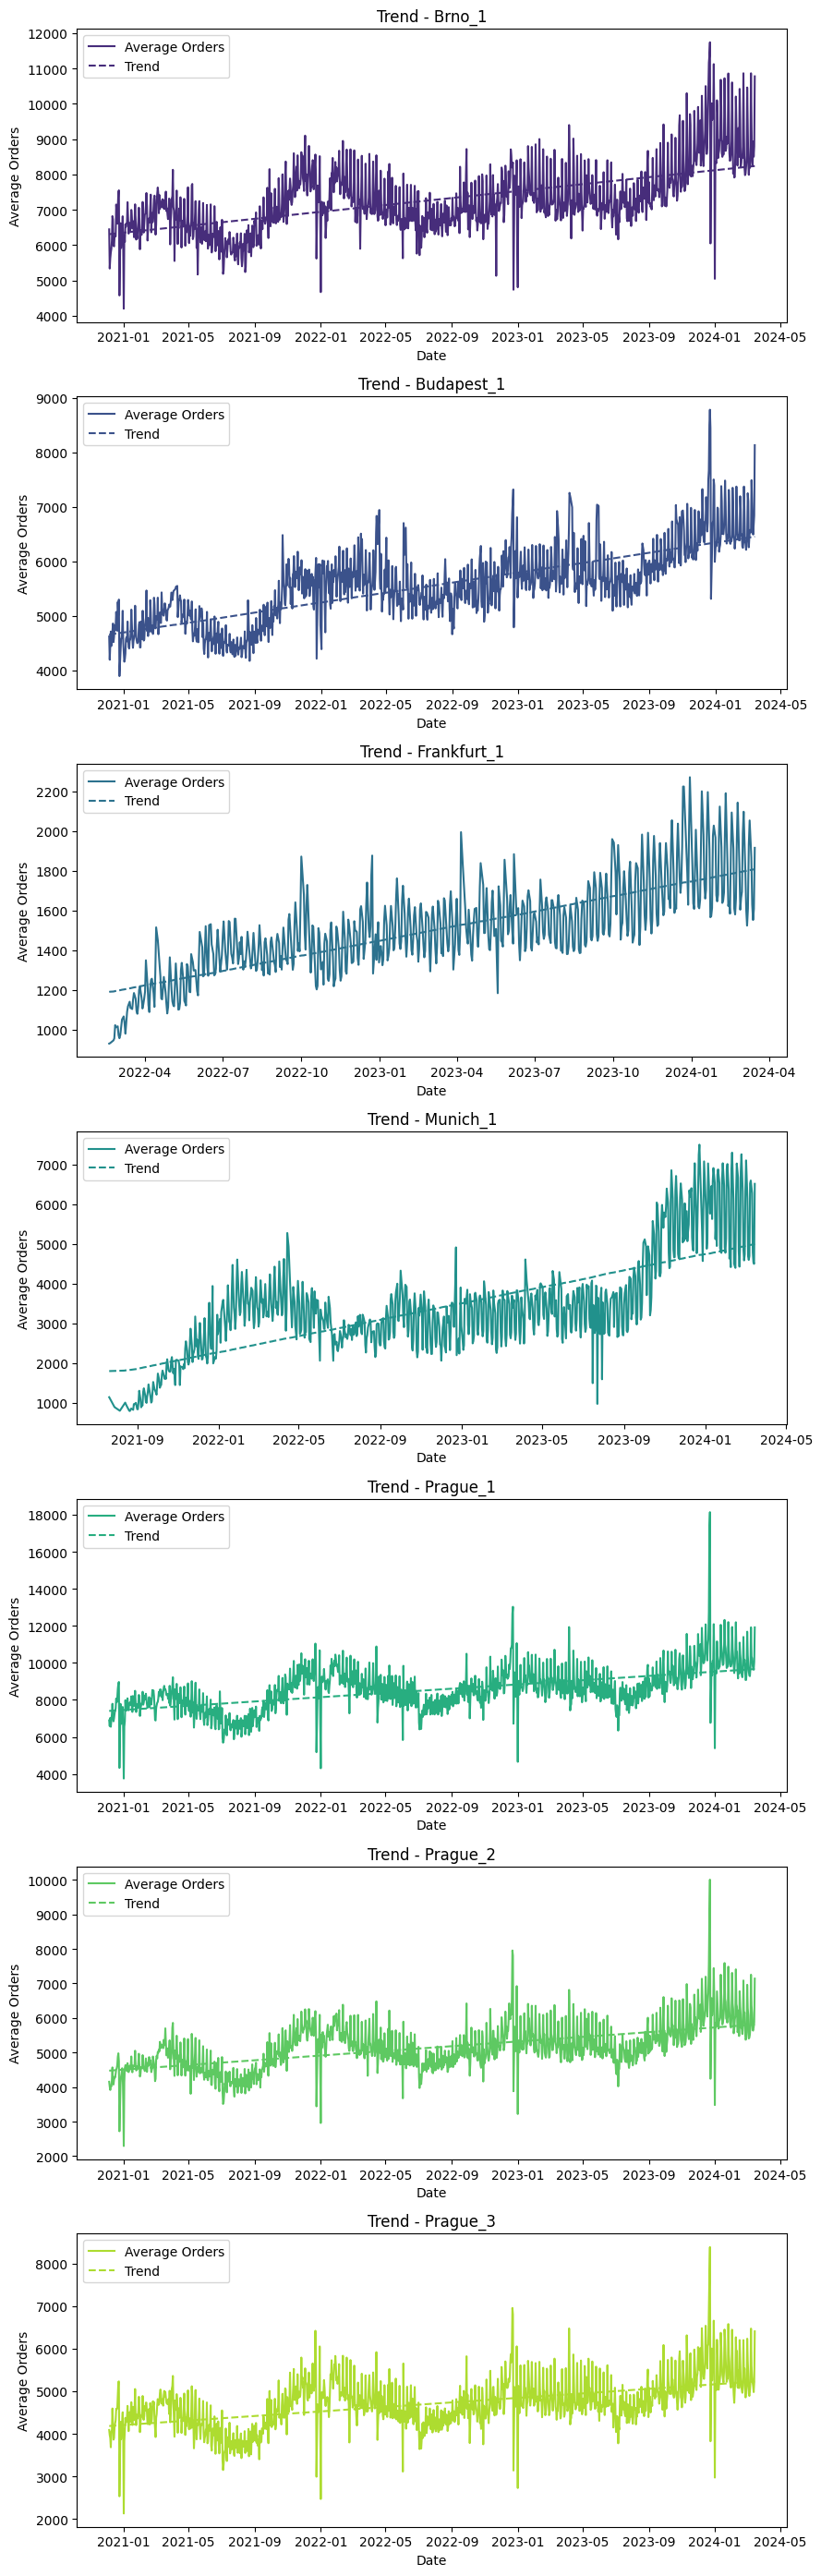

In [35]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define color palette
colors = sns.color_palette("viridis", n_colors=len(train['warehouse'].unique()))

# Create subplots
fig, axes = plt.subplots(len(train['warehouse'].unique()), 1, figsize=(9, 4 * len(train['warehouse'].unique())))
ax = axes.flatten()

# Iterate over each warehouse and plot the trend
for i, (ind, c) in enumerate(train.groupby('warehouse')):
    # Compute average orders per date
    temp = c.groupby(c.date).orders.mean()
    
    # Fit a polynomial of degree 1 (linear fit) to the data
    poly = np.polynomial.Polynomial.fit(range(len(temp.index)), temp, deg=1)
    
    # Plot the data and the polynomial fit
    ax[i].plot(temp.index, temp, label='Average Orders', color=colors[i])
    ax[i].plot(temp.index, poly(range(len(temp.index))), linestyle='--', color=colors[i], label='Trend')
    
    # Set title and labels
    ax[i].set_title(f'Trend - {ind}')
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Average Orders')
    ax[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


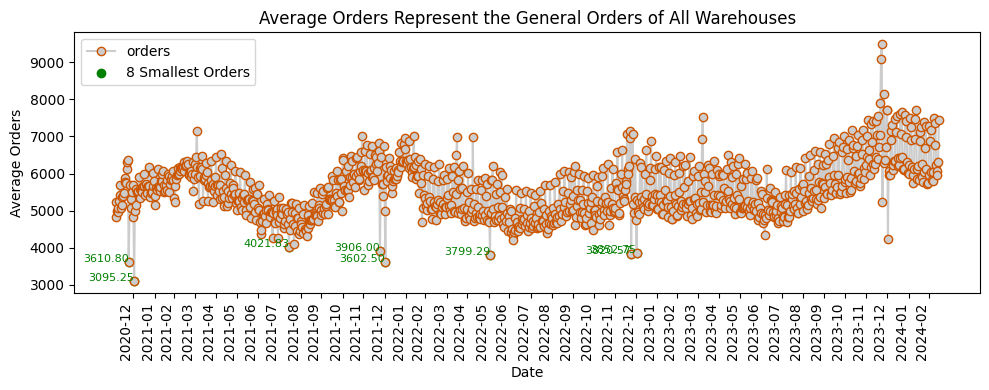

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train is your DataFrame
all_orders = train.copy()
all_orders.reset_index(inplace=True)
all_orders = all_orders.set_index('date')
all_orders = all_orders.set_index(['warehouse'], append=True)

# Calculate average orders per date
average_orders = all_orders.groupby('date')['orders'].mean()

# Plot the average orders
fig, ax = plt.subplots(figsize=(10, 4))
average_orders.plot(ax=ax, 
                    markeredgecolor='#CC5500', 
                    linestyle='-', 
                    marker='o', 
                    color='0.8')

# Add vertical lines for December (if desired)
# for date in dates_to_plot:
#     if date.month == 12:
#         ax.axvline(date, color='red', linestyle='--', linewidth=0.7)

# Identify and plot smallest and largest orders
smallest_orders = average_orders.nsmallest(8)
largest_orders = average_orders.nlargest(10)
dates_to_plot = pd.date_range(start=average_orders.index.min(), 
                              end=average_orders.index.max(), 
                              freq='1M')
                              
# Scatter plot for the smallest orders
smallest_scatter = ax.scatter(smallest_orders.index, 
                              smallest_orders.values, 
                              color='green', 
                              label='8 Smallest Orders')

# Annotate the smallest orders with their values
for date, value in smallest_orders.items():
    ax.text(date, value, f'{value:.2f}', color='green', fontsize=8, ha='right')

# Format the x-axis
ax.set_xticks(dates_to_plot)
ax.set_xticklabels(dates_to_plot.strftime('%Y-%m'), rotation=90)

# Set plot title and labels
ax.set_title('Average Orders Represent the General Orders of All Warehouses')
ax.set_xlabel('Date')
ax.set_ylabel('Average Orders')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


The graph shows a general trend of increasing average orders over time, with some seasonal fluctuations.
some seasonal fluctuations in average orders. For example, there appears to be a spike in average orders at the end of the year

In [37]:
# Columns to convert to categorical
cat_features = ['warehouse', 'holiday_name']
num_features      = ['holiday','shops_closed','winter_school_holidays']
temporal_features = ['date']
# Convert specified columns to categorical data type
for df in [train, test]:
    df[cat_features] = df[cat_features].astype('category')



# 5.6 Feature Distribution

/tmp/ipykernel_33/482672571.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to make room for suptitle


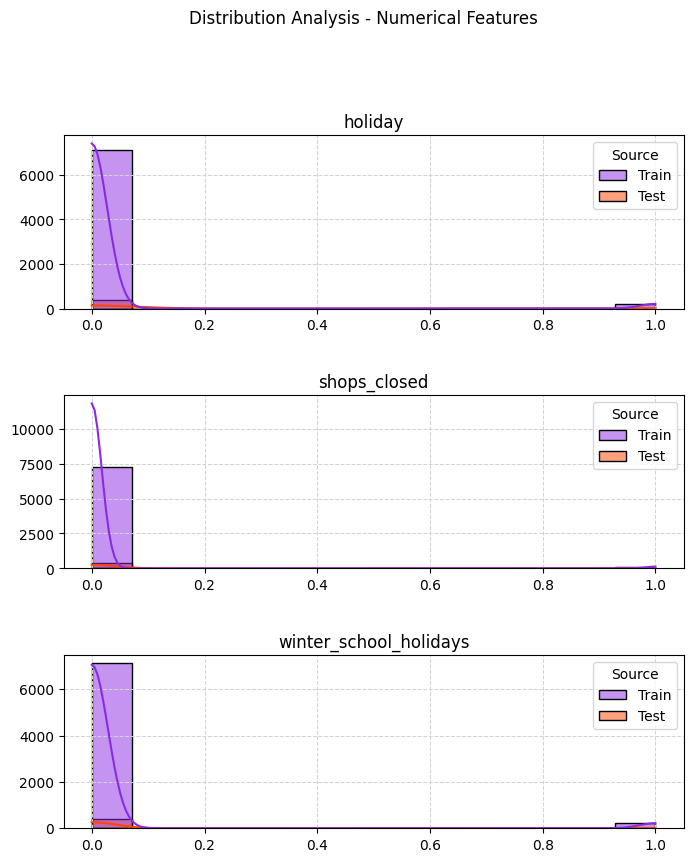

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_numerical():
    # Concatenate train and test datasets, adding a 'Source' column
    df = pd.concat([train[num_features].assign(Source='Train'), 
                    test[num_features].assign(Source='Test')], 
                   ignore_index=True)
    
    # Set up subplots
    fig, axes = plt.subplots(len(num_features), 1, figsize=(8, len(num_features) * 3),
                             gridspec_kw={'hspace': 0.5})
    axes = axes.flatten()
    
    # Loop through each numerical feature and plot its distribution
    for i, col in enumerate(num_features):
        ax = axes[i]
        sns.histplot(data=df, x=col, hue='Source', palette=['#8A2BE2','#FF4500'], ax=ax, kde=True)
        ax.set_title(f'{col}', fontsize=12)
        ax.grid(visible=True, which='both', linestyle='--', color='lightgrey', linewidth=0.75)
        ax.set(xlabel='', ylabel='')
    
    # Set the main title for the entire figure
    plt.suptitle('Distribution Analysis - Numerical Features', fontsize=12, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to make room for suptitle
    plt.show()

# Example usage
num_features = ['holiday', 'shops_closed', 'winter_school_holidays']
plot_numerical()


For all distributions with positive skewness and below zero, applying a logarithmic transformation can help bring them closer to normal. This contributes to some machine learning models.


# 5.7 Count Plot- that shows the frequency (count) of occurrences of categorical values

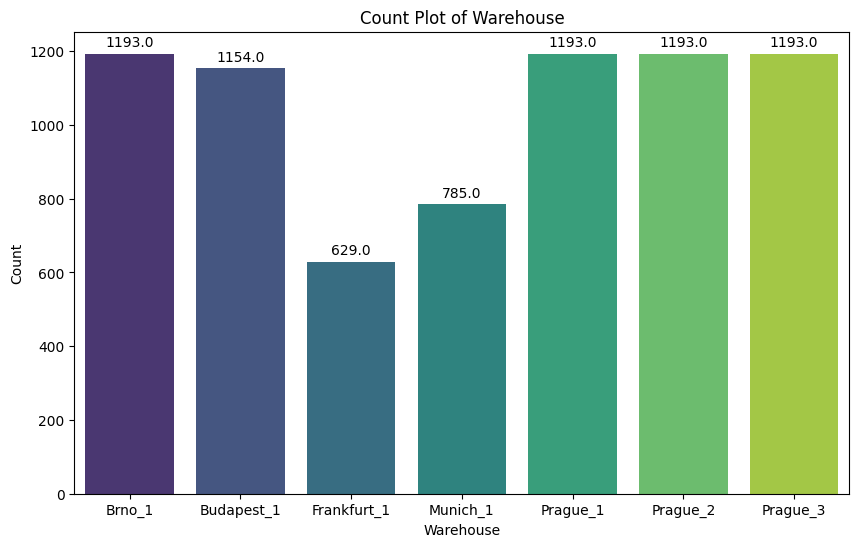

In [39]:

# Create a count plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=train, x='warehouse', palette='viridis')

# Add labels to each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                xy=(p.get_x() + p.get_width() / 2, height), 
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', 
                va='bottom')

# Set labels and title
ax.set_xlabel('Warehouse')
ax.set_ylabel('Count')
ax.set_title('Count Plot of Warehouse')

plt.show()

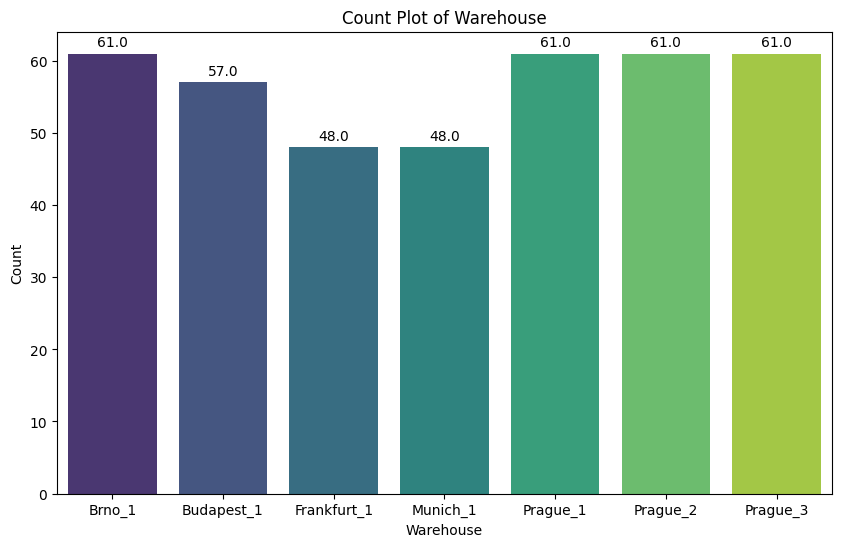

In [40]:

# Create a count plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=test, x='warehouse', palette='viridis')

# Add labels to each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                xy=(p.get_x() + p.get_width() / 2, height), 
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', 
                va='bottom')

# Set labels and title
ax.set_xlabel('Warehouse')
ax.set_ylabel('Count')
ax.set_title('Count Plot of Warehouse')

plt.show()

# 5.8 Correlation of Categorical features

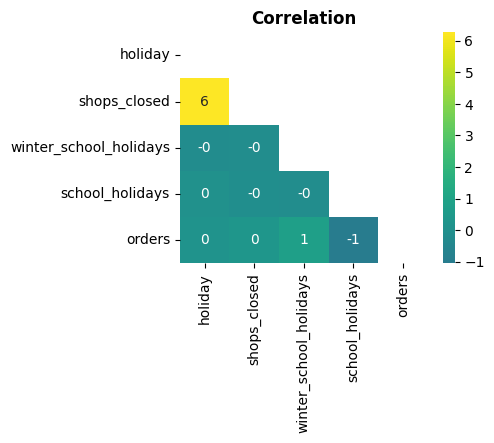

In [41]:
corr_features = [f for f in initial_features+[target] if f not in ['date','id']+cat_features]
cc = np.corrcoef(train[corr_features], rowvar=False)
mask = np.zeros_like(cc)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(4, 3))
sns.heatmap(cc*10, center=0, cmap='viridis', annot=True, fmt='.0f',
            xticklabels=corr_features, yticklabels=corr_features,mask=mask)
plt.title('Correlation',fontweight='bold')
plt.show()

Holiday is correlated with shops_closed.

# STEP 6: Data Preprocessing 

Class Definition

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupKFold, TimeSeriesSplit
from sklearn.compose import TransformedTargetRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        return x[self.cols]

class DateProcessor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self, X):
        x_copy = X.copy()
        x_copy['year'] = x_copy['date'].dt.year
        x_copy['month'] = x_copy['date'].dt.month
        x_copy['day']   = x_copy['date'].dt.day
        x_copy['dayofweek'] = x_copy['date'].dt.dayofweek
        x_copy['sin_month']=np.sin(2*np.pi*x_copy['month']/12)
        x_copy['cos_month']=np.cos(2*np.pi*x_copy['month']/12)
        x_copy['sin_day']=np.sin(2*np.pi*x_copy['day']/30)
        x_copy['cos_day']=np.cos(2*np.pi*x_copy['month']/30)
        
        return x_copy.drop('date',axis=1)
    
oof, scores, test_preds   = {}, {}, {} 

def MAPE(y_true,y_pred):
    return np.mean(np.abs(y_pred-y_true)/y_true)


 
kf = GroupKFold(n_splits=5)
tss = TimeSeriesSplit(n_splits=5)

def cross_validate(model, label=''):
    
    if label is None:
        label = type(model).__name__
        
    X = train.copy()
    y = X.pop('orders')
    
    val_scores_mape, val_scores_mae, dates = [], [], [],    
    
    y_preds = np.zeros((len(train)))
    for i, (trx_idx, val_idx) in enumerate(tss.split(X,y,groups=X['warehouse'])):
        X_train = X.iloc[trx_idx]
        y_train = y.iloc[trx_idx]
                
        X_val   = X.iloc[val_idx]
        y_val   = y.iloc[val_idx]            
    
        model.fit(X_train,y_train)
        y_pred = model.predict(X_val)
        y_preds[val_idx] += y_pred
        mape = MAPE(y_val,y_pred)
        val_scores_mape.append(mape)
        val_scores_mae.append(mean_absolute_error(y_val,y_pred))        
        
        print(f'Fold {i+1}: MAPE: {mape} | MAE: {mean_absolute_error(y_val,y_pred)} ')
    
    
    oof[label] = y_preds
    scores[label] = np.mean(val_scores_mape)
    printColor(f'MAPE: {np.mean(val_scores_mape)} +- {np.std(val_scores_mape)} | MAE: {np.mean(val_scores_mae)} +- {np.std(val_scores_mae)} | {label}')     
        
   
    if SUBMIT:
        X = train.copy()
        y = X.pop('orders')
        y_preds = np.zeros((len(test)))
        model.fit(X,y)
        y_preds += model.predict(test)
    test_preds[label] = y_preds  


In [43]:

cross_validate(make_pipeline(FeatureSelector(initial_features),
                             DateProcessor(),
                             MEstimateEncoder(cols=cat_features),
                             TransformedTargetRegressor(
                                          XGBRegressor(enable_categorical=False,
                                                       random_state=42,                                                                                                              
                                                       n_estimators=100),
                                          func=np.log1p,
                                          inverse_func=np.expm1)
                                          ),'XGB')



Fold 1: MAPE: 0.172973833351148 | MAE: 1194.0677517183667 
Fold 2: MAPE: 0.112972757173056 | MAE: 574.669429002389 
Fold 3: MAPE: 0.284162305280903 | MAE: 674.0603127155944 
Fold 4: MAPE: 1.5120262206190258 | MAE: 2869.465789769969 
Fold 5: MAPE: 0.0808062913924036 | MAE: 431.46746771275167 
MAPE: 0.4325882815633072 +- 0.544154545780627 | MAE: 1148.746150183814 +- 898.0322444150776 | XGB


In [44]:
cross_validate(
    make_pipeline(
        FeatureSelector(initial_features),  # Ensure 'initial_features' is a list of column names
        DateProcessor(),
        ColumnTransformer(
            transformers=[
                ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_features)
            ],
            remainder='passthrough'
        ),
        TransformedTargetRegressor(
            RandomForestRegressor(
                random_state=42,
                verbose=0,
                max_depth=9
            ),
            func=np.log1p,
            inverse_func=np.expm1
        )
    ),
    'RF'
)


Fold 1: MAPE: 0.17685099933274082 | MAE: 1203.1226074729718 
Fold 2: MAPE: 0.1569437563542187 | MAE: 832.8600053882162 
Fold 3: MAPE: 0.4724057784487488 | MAE: 1074.1419946020756 
Fold 4: MAPE: 1.4479238753145087 | MAE: 2778.6227300602786 
Fold 5: MAPE: 0.12070658117309174 | MAE: 665.0863894593958 
MAPE: 0.4749661981246617 +- 0.50242691384412 | MAE: 1310.7667453965876 +- 757.2948829907019 | RF


In [45]:
cross_validate(
        make_pipeline( FeatureSelector(initial_features),
            DateProcessor(),
            ColumnTransformer(
                transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'), cat_features)
                ],
                remainder='passthrough'
            ),
            TransformedTargetRegressor(
                AdaBoostRegressor(random_state=42, n_estimators=100),
                func=np.log1p,
                inverse_func=np.expm1
            )
        ),
        'AdaBoost'
    )

Fold 1: MAPE: 0.21547111269748098 | MAE: 1413.0361793600111 
Fold 2: MAPE: 0.3107867132377331 | MAE: 1585.672476454344 
Fold 3: MAPE: 0.5400946578967007 | MAE: 1696.1193199317415 
Fold 4: MAPE: 1.691153771537287 | MAE: 3046.5166202345235 
Fold 5: MAPE: 0.19989459131051734 | MAE: 1104.8416879354577 
MAPE: 0.5914801693359438 +- 0.5631045007904595 | MAE: 1769.2372567832158 +- 669.1465479291019 | AdaBoost


In [46]:
cross_validate(
        make_pipeline(
            FeatureSelector(initial_features),
            DateProcessor(),
            ColumnTransformer(
                transformers=[
                    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_features)
                ],
                remainder='passthrough'
            ),
            TransformedTargetRegressor(
                GradientBoostingRegressor(random_state=42),
                func=np.log1p,
                inverse_func=np.expm1
            )
        ),
        'GBR'
    )

Fold 1: MAPE: 0.14008403393272562 | MAE: 919.0595768282783 
Fold 2: MAPE: 0.08666490966029522 | MAE: 418.86229953606505 
Fold 3: MAPE: 0.439749180634963 | MAE: 1048.4542597004033 
Fold 4: MAPE: 1.5394528779756578 | MAE: 2801.0328099290946 
Fold 5: MAPE: 0.07445474544447062 | MAE: 418.487306551622 
MAPE: 0.4560811495296225 +- 0.5578390955900887 | MAE: 1121.1792505090928 +- 878.0745225320903 | GBR


In [47]:
cross_validate(
        make_pipeline(
            FeatureSelector(initial_features),
            DateProcessor(),
            ColumnTransformer(
                transformers=[
                    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_features)
                ],
                remainder='passthrough'
            ),
            TransformedTargetRegressor(
                SVR(),
                func=np.log1p,
                inverse_func=np.expm1
            )
        ),
        'SVR'
    )

Fold 1: MAPE: 0.2267838681473898 | MAE: 1427.5957272809958 
Fold 2: MAPE: 0.5390597926325174 | MAE: 2620.3984046808605 
Fold 3: MAPE: 0.7592741934974002 | MAE: 2406.311608486537 
Fold 4: MAPE: 1.9030427270499577 | MAE: 3412.8561562657387 
Fold 5: MAPE: 0.20559598959398873 | MAE: 715.2359420816772 
MAPE: 0.7267513141842508 +- 0.6231400568681532 | MAE: 2116.479567759162 +- 944.094667863175 | SVR


In [48]:
cross_validate(
        make_pipeline(
            FeatureSelector(initial_features),
            DateProcessor(),
            ColumnTransformer(
                transformers=[
                    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_features)
                ],
                remainder='passthrough'
            ),
            TransformedTargetRegressor(
                MLPRegressor(random_state=42),
                func=np.log1p,
                inverse_func=np.expm1
            )
        ),
        'MLP'
    )

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1: MAPE: 0.13847662652038986 | MAE: 910.727147556216 


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2: MAPE: 0.19230483777823698 | MAE: 978.178745398858 
Fold 3: MAPE: 0.3764213564495659 | MAE: 948.1284018108986 
Fold 4: MAPE: 1.7534069696011554 | MAE: 3134.6367250497133 
Fold 5: MAPE: 0.28854903348910005 | MAE: 1612.8986560953567 
MAPE: 0.5498317647676897 +- 0.607284391756013 | MAE: 1516.9139351822087 +- 849.4062750746766 | MLP


In [49]:

params = {'verbose': -1,'random_state': 42}
cross_validate(make_pipeline(FeatureSelector(initial_features),
                             DateProcessor(),
                             TransformedTargetRegressor(
                                          LGBMRegressor(**params),
                                          func=np.log1p,
                                          inverse_func=np.expm1)
                                          ),'LGBM')

Fold 1: MAPE: 0.15663226702823868 | MAE: 1077.4325540550606 
Fold 2: MAPE: 0.10059228050374172 | MAE: 552.5564679812403 
Fold 3: MAPE: 0.2962546947218277 | MAE: 722.6530356079896 
Fold 4: MAPE: 0.4260534657621227 | MAE: 1298.3715520611202 
Fold 5: MAPE: 0.17416170279956147 | MAE: 958.9247559213235 
MAPE: 0.23073888216309846 +- 0.11667991585242948 | MAE: 921.9876731253469 +- 262.0709814015553 | LGBM


In [50]:
result = []
for label in oof.keys():
    score = MAPE(train['orders'], oof[label])
    result.append((label, score))
result_df = pd.DataFrame(result, columns=['label', 'score'])
result_df.sort_values('score', inplace=True, ascending=True)
result_df

label     score
6      LGBM  0.359124
0       XGB  0.527286
3       GBR  0.546858
1        RF  0.562591
5       MLP  0.624962
2  AdaBoost  0.659660
4       SVR  0.772355

/tmp/ipykernel_33/2718581171.py:36: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal')


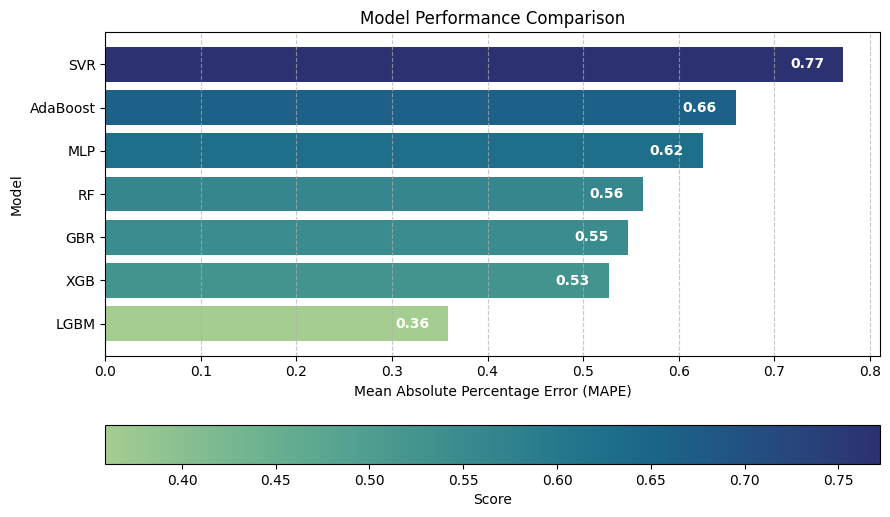

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming result_df contains 'label' and 'score' columns
result_df = pd.DataFrame(result, columns=['label', 'score'])
result_df.sort_values('score', inplace=True, ascending=True)

# Define the colormap
cmap = plt.get_cmap('crest')
norm = plt.Normalize(result_df['score'].min(), result_df['score'].max())

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(result_df['label'], result_df['score'], color=cmap(norm(result_df['score'])))

# Adding data labels inside the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width - 0.02, bar.get_y() + bar.get_height() / 2, 
             f'{width:.2f}', 
             va='center', 
             ha='right', 
             color='white', 
             fontsize=10, 
             fontweight='bold')

plt.xlabel('Mean Absolute Percentage Error (MAPE)')
plt.ylabel('Model')
plt.title('Model Performance Comparison')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal')
cbar.set_label('Score')

plt.show()


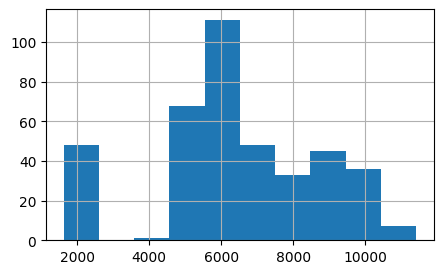

In [52]:
if SUBMIT:
    sub['orders'] = test_preds['LGBM']*1.01
    sub['orders'].hist(figsize=(5,3))
    sub.to_csv('submission.csv',index=False)


* LGBM obtained better results in this first stage, and also obtained a lower standard deviation in relation to the others.
* For better results, you must: tune the LGBM hyperparameters, and adapt the cross-validation, so that we can leave the results correlated with the LB.
* An ensemble can be valuable.
* train different models for each cluster found.